# **АНАЛИЗ ВВП ГАНЫ. ПОСТРОЕНИЕ МОДЕЛИ ВРЕМЕННОГО РЯДА**

Представьте, что вы работаете в государственной компании, предоставляющей анализ экономической ситуации в мире по заказу государства.

Перед вами стоит задача проанализировать ВВП африканской страны Гана. Для этого вам предоставили [показатели ВВП](https://lms.skillfactory.ru/assets/courseware/v1/cf3fb9ca311981f5cc6b6f0a40621388/asset-v1:SkillFactory+DSPR-2.0+14JULY2021+type@asset+block/ghana_gdp.zip) Ганы за 62 года. Вам предстоит исследовать временной ряд, изучить его свойства, построить модели и сделать выводы по результатам.

## **1. Подготовка данных**

In [1]:
import pandas as pd
import numpy as np
from plotly.subplots import make_subplots  
import plotly.graph_objects as go  
import plotly.express as  px
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.graphics.tsaplots as sgt
from statsmodels.tsa.arima.model import ARIMA
import pmdarima as pm
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error
from statsmodels.tsa.seasonal import seasonal_decompose
from matplotlib import pyplot as plt
from sklearn.linear_model import LinearRegression
from prophet import Prophet
import plotly.io as pio
pio.renderers.default= 'png'

In [2]:
ghana_gdp_zip = pd.read_csv('C:\Python\data\ghana_gdp.zip', index_col=['year'], parse_dates=['year'])
ghana_gdp = ghana_gdp_zip.copy()
ghana_gdp.head()

,GDP (current US$)
year,
1960-01-01,1.217087e+09
1961-01-01,0.000000e+00
1962-01-01,1.382353e+09
1963-01-01,1.540616e+09
1964-01-01,1.731092e+09


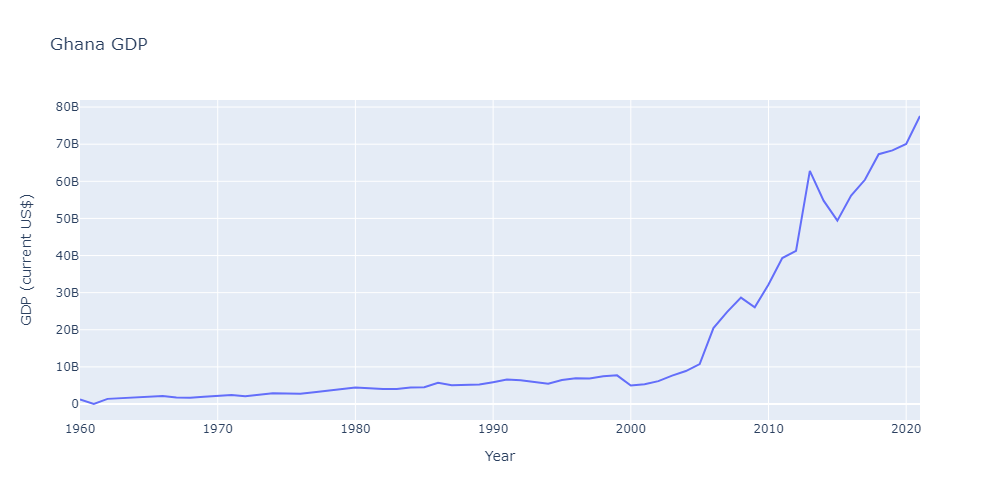

In [3]:
# визуализируем ВВП Ганы по годам
fig = px.line(y=ghana_gdp['GDP (current US$)'], x=ghana_gdp.index, title='Ghana GDP',
              labels={'y':'GDP (current US$)', 'x': 'Year'},
              width=1000)
fig.show()

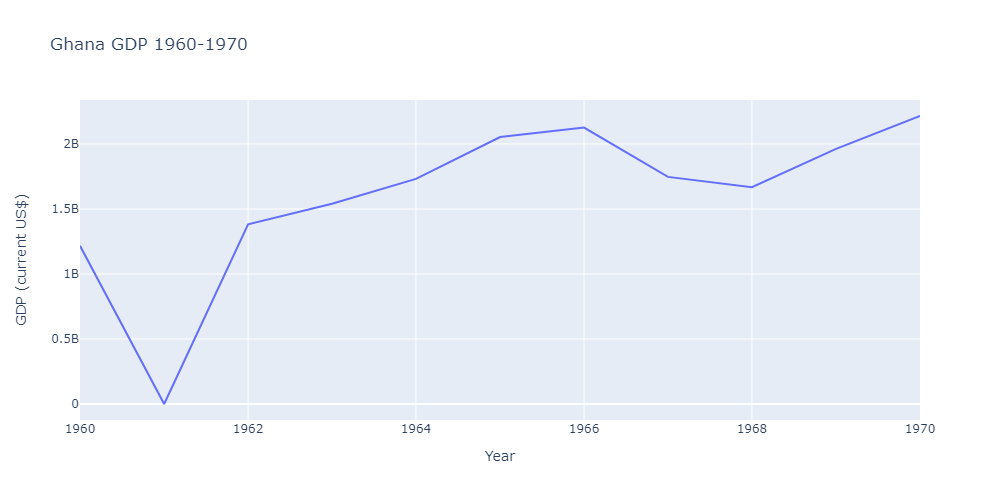

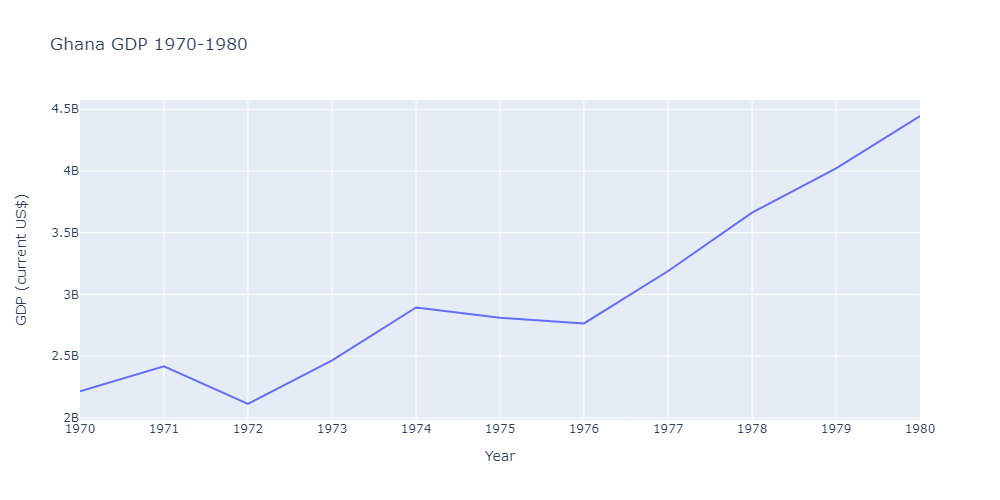

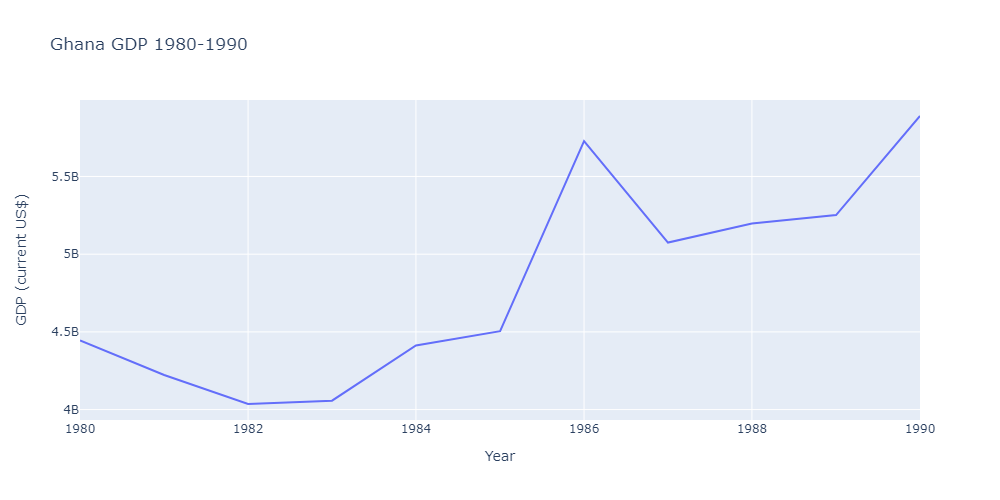

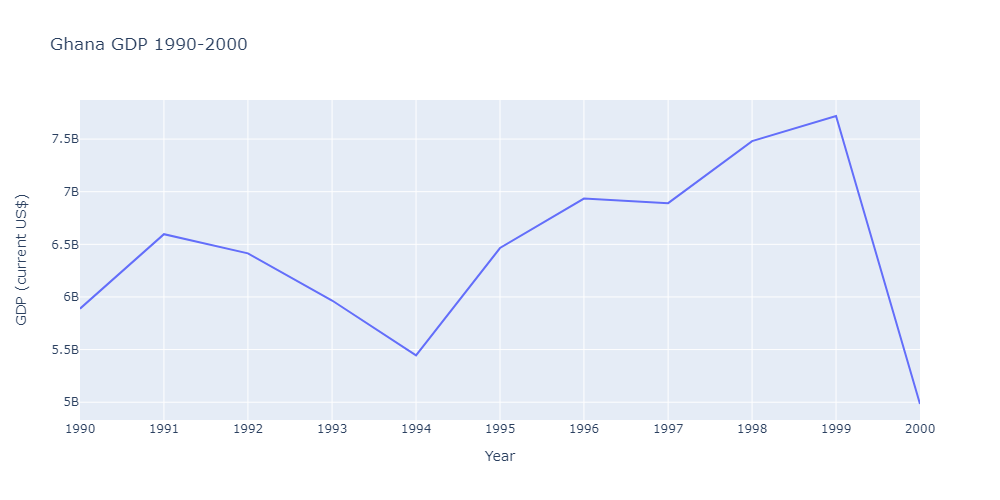

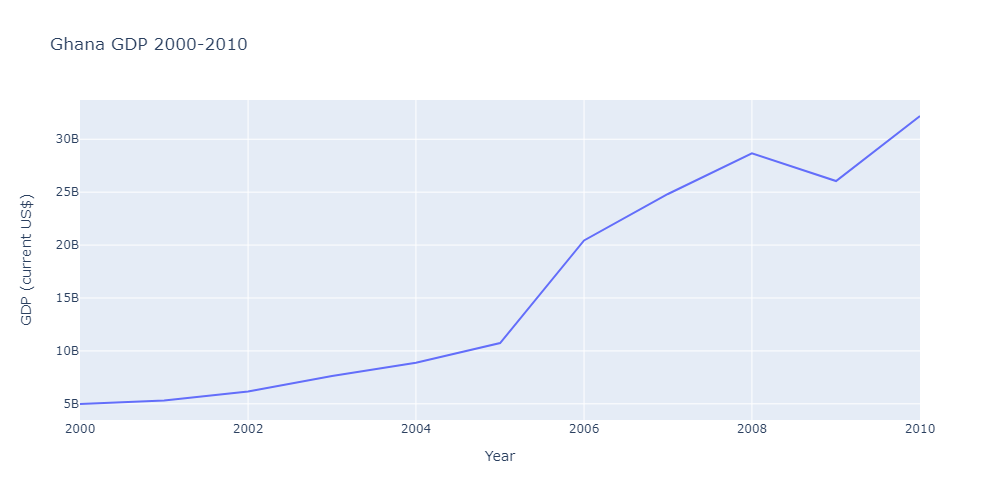

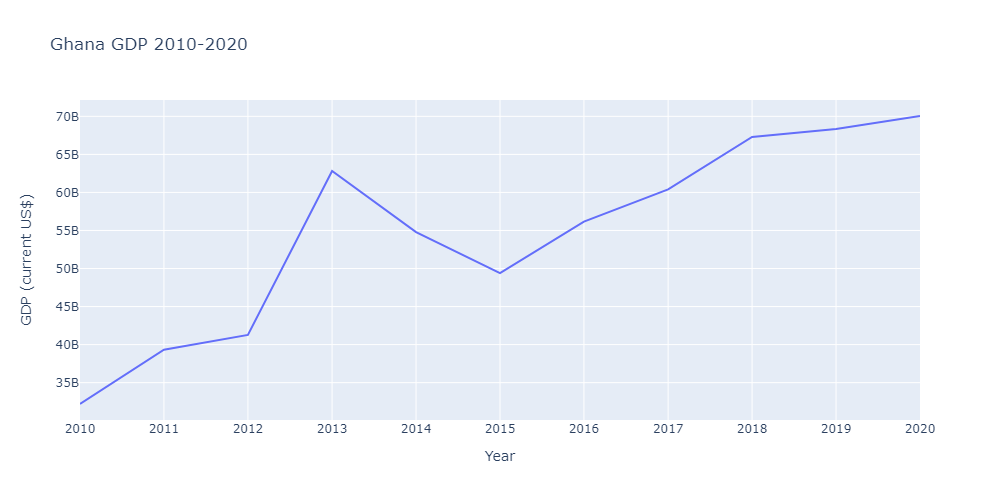

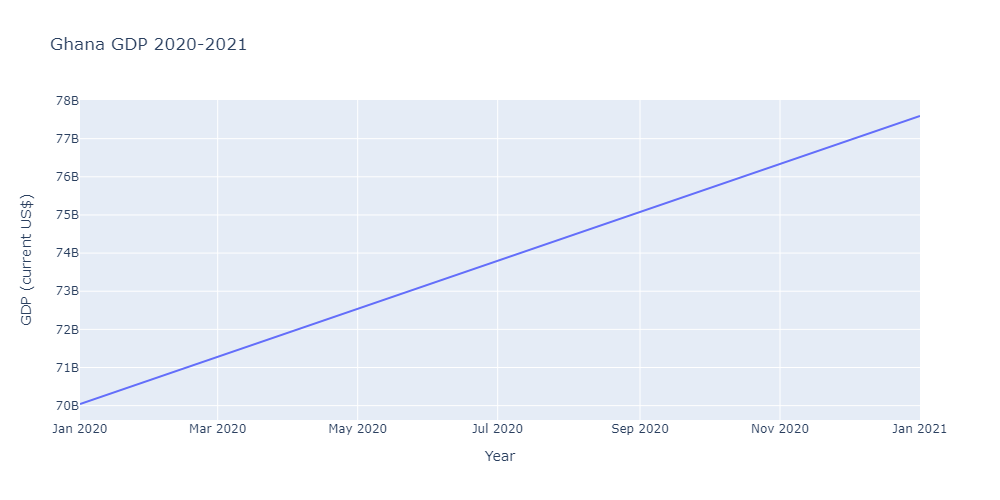

In [4]:
# визуализируем ВВП Ганы по десятилетиям
start = 1960
for i in range(0, 7):
    fin = start + 10
    if fin < 2030:
        fig = px.line(y=ghana_gdp['GDP (current US$)'][str(start):str(fin)], x=ghana_gdp.index[(i*10):(i*10+11)], title='Ghana GDP' + ' ' + str(start) + '-' + str(fin),
              labels={'y':'GDP (current US$)', 'x': 'Year'},
              width=1000)
        fig.show()
        start = fin
    else:
        fig = px.line(y=ghana_gdp['GDP (current US$)'][str(start):str(fin-9)], x=ghana_gdp.index[(i*10):(i*10+2)], title='Ghana GDP' + ' ' + str(start) + '-' + str(fin-9),
              labels={'y':'GDP (current US$)', 'x': 'Year'},
              width=1000)
        fig.show()    

In [5]:
# создадим датафрейм, где будут два признака - dif_ghana(разница ВВП за десятилетие, US$) и dif_ghana_fois(во сколько раз вырос ВВП)
ghana_10 = pd.DataFrame()
start = 1960
for i in range(0, 7):
    fin = start + 10
    if fin < 2030:
        dif_ghana = ghana_gdp['GDP (current US$)'][str(fin):str(fin)].iloc[0] - ghana_gdp['GDP (current US$)'][str(start):str(start)].iloc[0]
        dif_ghana_fois = ghana_gdp['GDP (current US$)'][str(fin):str(fin)].iloc[0] / ghana_gdp['GDP (current US$)'][str(start):str(start)].iloc[0]
        dif_df = pd.DataFrame(data = {'dif':dif_ghana, 'dif_fois':dif_ghana_fois}, index=[fin])
        ghana_10 = pd.concat([ghana_10, dif_df], axis=0)
        start = fin
    else:
        dif_ghana = ghana_gdp['GDP (current US$)'][str(fin-9):str(fin-9)].iloc[0] - ghana_gdp['GDP (current US$)'][str(start):str(start)].iloc[0]
        dif_ghana_fois = ghana_gdp['GDP (current US$)'][str(fin-9):str(fin-9)].iloc[0] / ghana_gdp['GDP (current US$)'][str(start):str(start)].iloc[0]
        dif_df = pd.DataFrame(data = {'dif':dif_ghana, 'dif_fois':dif_ghana_fois}, index=[fin-9])
        ghana_10 = pd.concat([ghana_10, dif_df], axis=0)
        
print(ghana_10)
ghana_10.loc[:'2020'].describe()   

               dif  dif_fois
1970  9.979426e+08  1.819944
1980  2.230199e+09  2.006848
1990  1.443947e+09  1.324831
2000 -9.061504e+08  0.846133
2010  2.721425e+10  6.461392
2020  3.784593e+10  2.175439
2021  7.551079e+09  1.107806


,dif,dif_fois
count,6.000000e+00,6.000000
mean,1.147102e+10,2.439098
std,1.668712e+10,2.029664
min,-9.061504e+08,0.846133
25%,1.109444e+09,1.448609
50%,1.837073e+09,1.913396
75%,2.096824e+10,2.133291
max,3.784593e+10,6.461392


Данные представлены за период: 1960-2021 гг. Рост ВВП в среднем составлял 2,4 раза за десятилетие(11,47 млрд. US$), максимальный рост был за 2000-2010(в 6,46 раз), ему предшестовал период падения ВВП с 1990 по 2020(в 0,84 раза).

Разделим датасет на тренировочный и тестовый выборки - в качестве тестового возьмём последние три года.

In [6]:
train_ghana = ghana_gdp.loc[:'2018-12-31']
test_ghana = ghana_gdp.loc['2019-01-01':]
train_ghana.shape, test_ghana.shape

((59, 1), (3, 1))

## **2. SMA (простое скользящее среднее)**

Для начала проведём декомпозицию временного ряда с разложением на компоненты - тренд, сезонность(цикличность), шум.

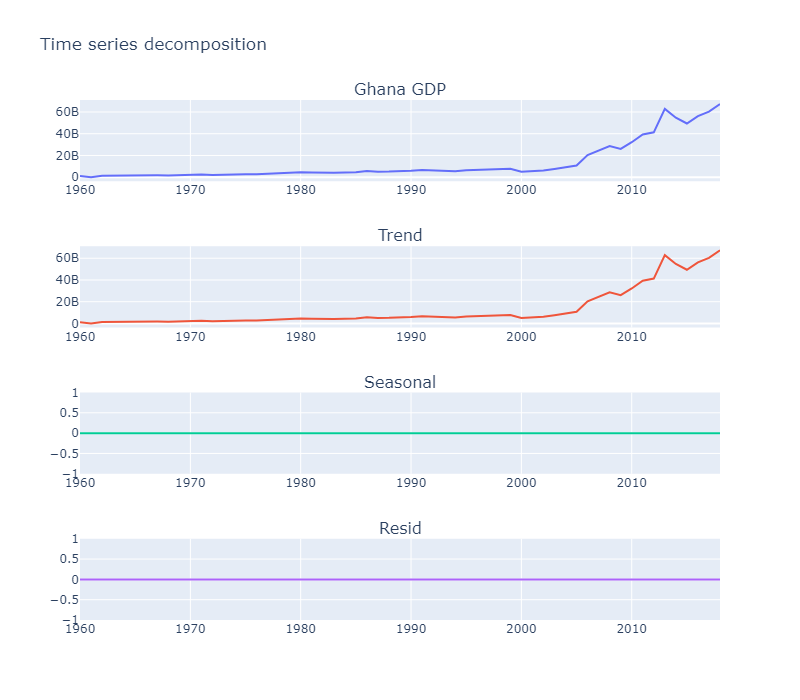

In [7]:
result = seasonal_decompose(train_ghana['GDP (current US$)'], model='additive')

fig = make_subplots(rows=4, cols=1, row_heights=[50, 50, 50, 50],subplot_titles=['Ghana GDP', 'Trend',
                                                    'Seasonal', 'Resid'])

fig.add_trace(go.Scatter(y=train_ghana['GDP (current US$)'], x= train_ghana.index, showlegend=False),row=1, col=1)
fig.add_trace(go.Scatter(y=result.trend, x= train_ghana.index, showlegend=False), row=2, col=1)
fig.add_trace(go.Scatter(y=result.seasonal, x= train_ghana.index, showlegend=False), row=3, col=1)
fig.add_trace(go.Scatter(y=result.resid, x= train_ghana.index, showlegend=False), row=4, col=1)

fig.update_layout(height=700, width=800, title_text='Time series decomposition')
fig.show()

- Резкий восходящий тренд прослеживается(на Ghana GDP, Trend) с 2004 года. С 1960 по 2004 наблюдается очень слабое изменение ВВП в сторону роста(ползучий график).
- Сезонность(цикличность) отсутвует - график Seasonal находится в нуле
- В Resid наблюдаем белый околонулевой шум

Рассмотрим сразу метод простого скользящего среднего(SMA), построенного на 3 окнах: 1, 5, 10 лет. Используем её как функцию для сглаживания.

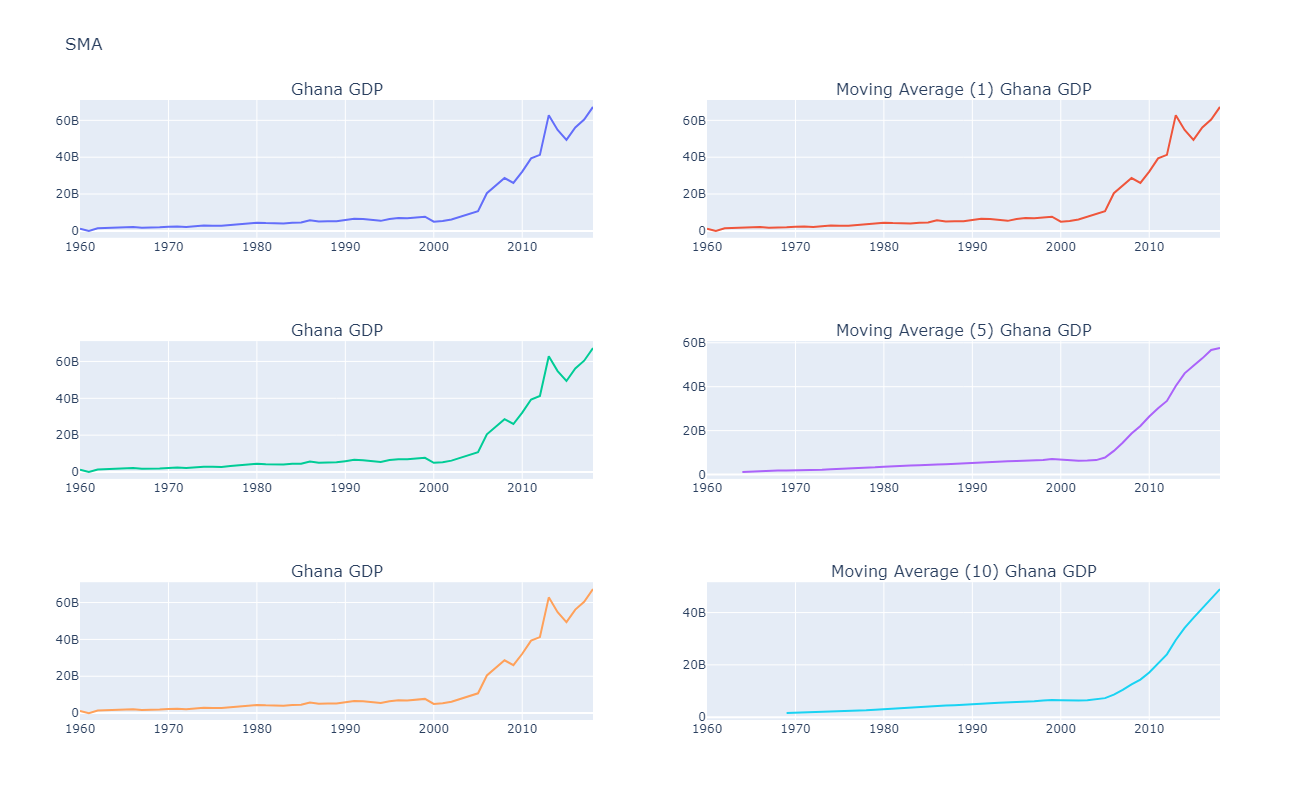

In [8]:
fig = make_subplots(rows=3, cols=2, column_widths=[50, 50], row_heights=[50, 50, 50], subplot_titles=['Ghana GDP', 'Moving Average (1) Ghana GDP',
                                                    'Ghana GDP', 'Moving Average (5) Ghana GDP',
                                                    'Ghana GDP', 'Moving Average (10) Ghana GDP'])

fig.add_trace(go.Scatter(y=train_ghana['GDP (current US$)'], x= train_ghana.index, showlegend=False),row=1, col=1)
fig.add_trace(go.Scatter(y=train_ghana['GDP (current US$)'].rolling(window=1).mean(), x= train_ghana.index, showlegend=False), row=1, col=2)

fig.add_trace(go.Scatter(y=train_ghana['GDP (current US$)'], x= train_ghana.index, showlegend=False), row=2, col=1)
fig.add_trace(go.Scatter(y=train_ghana['GDP (current US$)'].rolling(window=5).mean(), x= train_ghana.index, showlegend=False), row=2, col=2)

fig.add_trace(go.Scatter(y=train_ghana['GDP (current US$)'], x= train_ghana.index, showlegend=False), row=3, col=1)
fig.add_trace(go.Scatter(y=train_ghana['GDP (current US$)'].rolling(window=10).mean(), x= train_ghana.index, showlegend=False), row=3, col=2)
fig.update_layout(height=800, width=1300, title_text='SMA')
fig.show()

На графиках SMA виден резкий восходящий тренд ВВП с 2004, тренд прослеживается на всех окнах - 1, 5, 10 лет. Окна в 5 и 10 лет хорошо отработали, сгладив коррекцию ВВП с 2013 по 2015 года.

Данные тренда SMA подтверждены и на декомпозиции временного ряда. 

Сделаем предсказание(графически) для SMA для 3 окна.

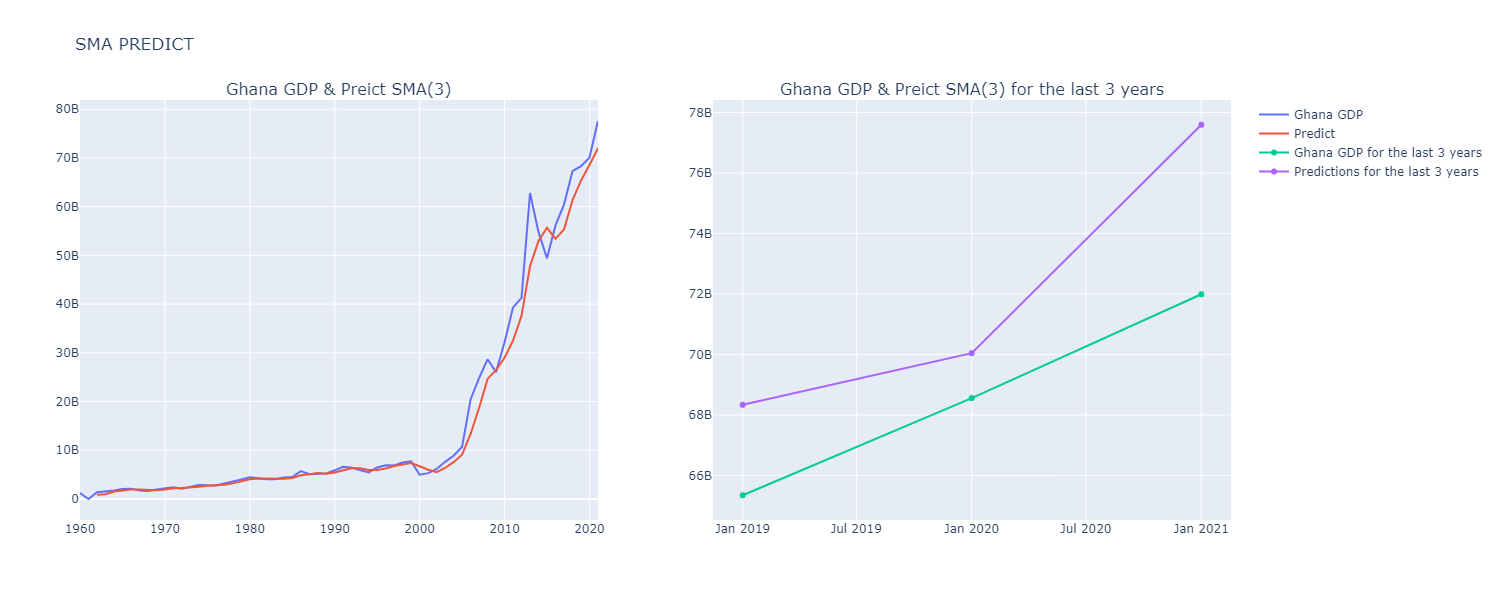

In [9]:
fig = make_subplots(rows=1, cols=2, subplot_titles=['Ghana GDP & Preict SMA(3)', 'Ghana GDP & Preict SMA(3) for the last 3 years'])

fig.add_trace(go.Scatter(y=ghana_gdp['GDP (current US$)'], x= ghana_gdp.index, showlegend=True, name='Ghana GDP'), row=1, col=1)
fig.add_trace(go.Scatter(y=ghana_gdp['GDP (current US$)'].rolling(window=3).mean(), x= ghana_gdp.index, showlegend=True, name='Predict'), row=1, col=1)
fig.add_trace(go.Scatter(y=ghana_gdp['GDP (current US$)'].rolling(window=3).mean().loc['2019-01-01':], x= test_ghana.index, showlegend=True, name='Ghana GDP for the last 3 years'), row=1, col=2)
fig.add_trace(go.Scatter(y=ghana_gdp['GDP (current US$)'].loc['2019-01-01':], x= test_ghana.index, showlegend=True, name='Predictions for the last 3 years'), row=1, col=2)
fig.update_layout(height=600, width=1500, title_text='SMA PREDICT')
fig.show()

Рассчитаем метрики для модели. Будем использовать MAPE и MSE.

In [10]:
MAPE = round(mean_absolute_percentage_error(test_ghana, ghana_gdp['GDP (current US$)'].rolling(window=3).mean().loc['2019-01-01':])*100, 2)
MSE = round(mean_squared_error(test_ghana, ghana_gdp['GDP (current US$)'].rolling(window=3).mean().loc['2019-01-01':])*100, 2)
print(f'MAPE for SMA = {MAPE}%')
print(f'MSE for SMA = {MSE}')

MAPE for SMA = 4.57%
MSE for SMA = 1.4175998301236838e+21


По графикам SMA PREDICT видно, что модель отрабатывает в большинстве случаев неплохо, повторяя график ВВП Ганы, для последних 3 года метрика MAPE составило 4,57%. Также можно отметить, что модель плохо предугадывает моменты времени с резкими изменениями значений ВВП - 2005-2009 гг, 2013-2015 т.е. в те года когда разброс значений сильно отличался от среднего. Последнее может говорить о нестационарности временного ряда.

Также стоит оговориться о том, что модель SMA хорошо работает при наличии тренда и при отсутсвии либо смене тренда, сезонных колебаниях отрабатывает себя плохо.

## **3. Оценка ряда. Выбор модели**

Проверим ряд на стационарность с помощью статистического теста Дики-Фуллера

In [11]:
test = adfuller(train_ghana['GDP (current US$)'])

print ('adf: ', test[0])
print ('p-value: ', test[1])
print ('Critical values: ', test[4])

if test[0]> test[4]['5%']: 
    print ('ряд нестационарен')
else:
    print ('ряд стационарен')

adf:  0.6529066974885349
p-value:  0.9888496277665572
Critical values:  {'1%': -3.5745892596209488, '5%': -2.9239543084490744, '10%': -2.6000391840277777}
ряд нестационарен


Ряд нестационарен, поэтому производим его дифференцирование для приведения к стационарности и вновь проведём тест.

In [12]:
df_diff_1 = train_ghana.diff(periods=5).dropna()
test = adfuller(df_diff_1['GDP (current US$)'])
print ('adf: ', test[0])
print ('p-value: ', test[1])
print ('Critical values: ', test[4])
if test[0]> test[4]['5%']: 
    print ('ряд нестационарен')
else:
    print ('ряд стационарен')

adf:  -3.598834530005187
p-value:  0.005783348166395402
Critical values:  {'1%': -3.5812576580093696, '5%': -2.9267849124681518, '10%': -2.6015409829867675}
ряд стационарен


Только пятая разность позволила привести ряд к стационарности(d=5). Построим коррелограммы - частиную и полную.

In [13]:
def plot_acf_pacf(series):
    plt.rcParams["figure.figsize"] = 18, 5

    fig, axes = plt.subplots(1, 2)
    
    sgt.plot_acf(series, ax = axes[0], zero=False, lags = 58)
    sgt.plot_pacf(series, ax = axes[1], method='yw', zero=False)
    plt.show()  

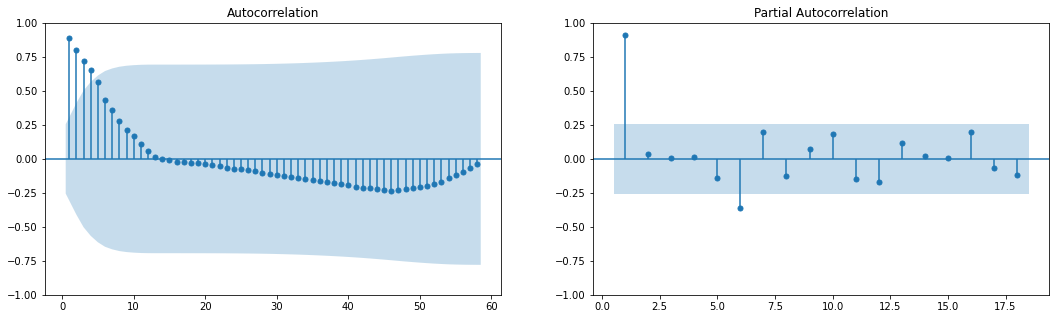

In [14]:
plot_acf_pacf(train_ghana['GDP (current US$)'])

Коррелограммы показывают, что в данных присутствуют зависимости - проявляется до 6 лаги включительно, имеется тренд. На частичной коррелограмме можно заметить выделяющийся пятый лаг(p=5).


Тест показал, что при пятом порядке интегрирования ряд ставновится стационарным. Так как ряд нестационарный, и нет необходимости учитывать экзогенные факторы, то выбирем тест **ARIMA** со следующими параметрами:

- p = 5 - кол-во лагов
- d = 5 - порядок дифференцирования
- q = 5 - порядок скользящего среднего


## **4. Построение модели. Подбор параметров**

Строим модель **ARIMA**, далее подберём оптимальные параметры для неё с помощью auto_arima.

In [15]:
arima_model = ARIMA(train_ghana, order = (5, 5, 5))
arima_model_fit = arima_model.fit()
arima_model_fit.summary()

c:\anaconda_adm\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency AS-JAN will be used.

c:\anaconda_adm\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency AS-JAN will be used.

c:\anaconda_adm\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency AS-JAN will be used.

c:\anaconda_adm\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

c:\anaconda_adm\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.

c:\anaconda_adm\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to c

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:      GDP (current US$)   No. Observations:                   59
Model:                 ARIMA(5, 5, 5)   Log Likelihood               -1286.997
Date:                Mon, 16 Jan 2023   AIC                           2595.994
Time:                        20:55:11   BIC                           2617.873
Sample:                    01-01-1960   HQIC                          2604.432
                         - 01-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -2.3808      1.347     -1.768      0.077      -5.020       0.258
ar.L2         -2.7472      2.967     -0.926      0.354      -8.562       3.067
ar.L3         -2.3340      3.869     -0.603      0.546      -9.918       5.250
ar.L4         -1.6539      3.361     -0.492      0.623      -8.241       4.934
ar.L5         -0.5785      1.745     -0.331      0.740      -3.999       2.842
ma.L1         -0.8021      1.409     -0.569      0.569      -3.564       1.960
ma.L2         -1.6137      1.705     -0.946      0.344      -4.956       1.729
ma.L3          1.4320      1.026      1.396      0.163      -0.578       3.442
ma.L4          0.7197      1.675      0.430      0.668      -2.564       4.004
ma.L5         -0.7067      0.851     -0.830      0.406      -2.375       0.962
sigma2      5.179e+19   2.62e-19   1.97e+38      0.000    5.18e+19    5.18e+19
===================================================================================
Ljung-Box (L1) (Q):                   1.02   Jarque-Bera (JB):                98.80
Prob(Q):                              0.31   Prob(JB):                         0.00
Heteroskedasticity (H):              23.36   Skew:                            -1.07
Prob(H) (two-sided):                  0.00   Kurtosis:                         9.27
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.6e+54. Standard errors may be unstable.
"""

In [16]:
smodel = pm.auto_arima(train_ghana, start_p=1, start_q=1,
                         test='adf',
                         max_p=16, max_q=20,                         
                         d=5, trace=True,
                         error_action='ignore',  
                         suppress_warnings=True,
                         seasonal=False, 
                         stepwise=True)

smodel.summary()

Performing stepwise search to minimize aic
 ARIMA(1,5,1)(0,0,0)[0]             : AIC=inf, Time=0.08 sec
 ARIMA(0,5,0)(0,0,0)[0]             : AIC=2769.012, Time=0.01 sec
 ARIMA(1,5,0)(0,0,0)[0]             : AIC=2727.454, Time=0.02 sec
 ARIMA(0,5,1)(0,0,0)[0]             : AIC=inf, Time=0.04 sec
 ARIMA(2,5,0)(0,0,0)[0]             : AIC=2671.030, Time=0.03 sec
 ARIMA(3,5,0)(0,0,0)[0]             : AIC=inf, Time=0.17 sec
 ARIMA(2,5,1)(0,0,0)[0]             : AIC=2636.893, Time=0.06 sec
 ARIMA(3,5,1)(0,0,0)[0]             : AIC=2629.599, Time=0.10 sec
 ARIMA(4,5,1)(0,0,0)[0]             : AIC=2614.679, Time=0.22 sec
 ARIMA(4,5,0)(0,0,0)[0]             : AIC=inf, Time=0.21 sec
 ARIMA(5,5,1)(0,0,0)[0]             : AIC=2616.887, Time=0.20 sec
 ARIMA(4,5,2)(0,0,0)[0]             : AIC=2586.410, Time=0.17 sec
 ARIMA(3,5,2)(0,0,0)[0]             : AIC=2605.766, Time=0.14 sec
 ARIMA(5,5,2)(0,0,0)[0]             : AIC=2587.543, Time=0.34 sec
 ARIMA(4,5,3)(0,0,0)[0]             : AIC=2589.870, T

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   59
Model:               SARIMAX(6, 5, 3)   Log Likelihood               -1268.969
Date:                Mon, 16 Jan 2023   AIC                           2557.939
Time:                        20:55:17   BIC                           2577.829
Sample:                    01-01-1960   HQIC                          2565.609
                         - 01-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.4523      0.614     -2.366      0.018      -2.655      -0.249
ar.L2         -1.8820      1.079     -1.745      0.081      -3.996       0.232
ar.L3         -1.7587      1.070     -1.644      0.100      -3.855       0.337
ar.L4         -1.7993      0.865     -2.080      0.038      -3.495      -0.104
ar.L5         -1.3603      0.682     -1.995      0.046      -2.697      -0.024
ar.L6         -0.9608      0.338     -2.846      0.004      -1.623      -0.299
ma.L1         -2.2393      0.726     -3.086      0.002      -3.662      -0.817
ma.L2          1.5874      1.525      1.041      0.298      -1.401       4.576
ma.L3         -0.3374      0.855     -0.395      0.693      -2.014       1.339
sigma2      1.744e+19   1.97e-19   8.87e+37      0.000    1.74e+19    1.74e+19
===================================================================================
Ljung-Box (L1) (Q):                   0.07   Jarque-Bera (JB):               112.83
Prob(Q):                              0.79   Prob(JB):                         0.00
Heteroskedasticity (H):              45.22   Skew:                            -1.01
Prob(H) (two-sided):                  0.00   Kurtosis:                         9.79
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.26e+54. Standard errors may be unstable.
"""

Строим модель ARIMA на оптимальных параметрах - ARIMA(6,5,3):

In [17]:
arima_model_opt = ARIMA(train_ghana, order = (6, 5, 3))
arima_model_opt_fit = arima_model_opt.fit()
arima_model_opt_fit.summary()

c:\anaconda_adm\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency AS-JAN will be used.

c:\anaconda_adm\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency AS-JAN will be used.

c:\anaconda_adm\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency AS-JAN will be used.

c:\anaconda_adm\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

c:\anaconda_adm\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.

c:\anaconda_adm\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to c

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:      GDP (current US$)   No. Observations:                   59
Model:                 ARIMA(6, 5, 3)   Log Likelihood               -1268.969
Date:                Mon, 16 Jan 2023   AIC                           2557.939
Time:                        20:55:18   BIC                           2577.829
Sample:                    01-01-1960   HQIC                          2565.609
                         - 01-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.4523      0.614     -2.366      0.018      -2.655      -0.249
ar.L2         -1.8820      1.079     -1.745      0.081      -3.996       0.232
ar.L3         -1.7587      1.070     -1.644      0.100      -3.855       0.337
ar.L4         -1.7993      0.865     -2.080      0.038      -3.495      -0.104
ar.L5         -1.3603      0.682     -1.995      0.046      -2.697      -0.024
ar.L6         -0.9608      0.338     -2.846      0.004      -1.623      -0.299
ma.L1         -2.2393      0.726     -3.086      0.002      -3.662      -0.817
ma.L2          1.5874      1.525      1.041      0.298      -1.401       4.576
ma.L3         -0.3374      0.855     -0.395      0.693      -2.014       1.339
sigma2      1.744e+19   1.97e-19   8.87e+37      0.000    1.74e+19    1.74e+19
===================================================================================
Ljung-Box (L1) (Q):                   0.07   Jarque-Bera (JB):               112.83
Prob(Q):                              0.79   Prob(JB):                         0.00
Heteroskedasticity (H):              45.22   Skew:                            -1.01
Prob(H) (two-sided):                  0.00   Kurtosis:                         9.79
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.26e+54. Standard errors may be unstable.
"""

Если сравнить две модели, то модель построенная по подобранным оптимальным параметрам(ARIMA(6,5,3)) выдаёт лучшую метрику AIC=2558.008 против модели ARIMA(5,5,5) с метрикой AIC=2595.996.

Выполним для неё предсказания:

In [18]:
# создадим отдельный датафрейм с индексами первоначального 
pred_df = pd.DataFrame(index = ghana_gdp.index)
# сделаем предсказания для test_ghana и запишем в новый признак model_preds
pred_df['model_preds'] = arima_model_opt_fit.predict(start = test_ghana.index[0], end = test_ghana.index[-1])

# перенесём истинные значения в новый датафрейм
pred_df['GDP (current US$)'] = ghana_gdp['GDP (current US$)']
# формируем доверительный интервал в 95%
forecast = arima_model_opt_fit.get_forecast(len(test_ghana.index))
forecast_df = forecast.conf_int(alpha = 0.05) # Confidence level of 95%
# добавим в датафрейм доверительный интервал для 3 последних значений
pred_df.at[test_ghana.index, 'model_preds_lower'] = forecast_df['lower GDP (current US$)']
pred_df.at[test_ghana.index, "model_preds_upper"] = forecast_df['upper GDP (current US$)']
pred_df.tail(4)

,model_preds,GDP (current US$),model_preds_lower,model_preds_upper
year,,,,
2018-01-01,NaN,6.729928e+10,NaN,NaN
2019-01-01,6.423538e+10,6.833754e+10,5.604903e+10,7.242172e+10
2020-01-01,7.064875e+10,7.004320e+10,5.716700e+10,8.413049e+10
2021-01-01,5.404978e+10,7.759428e+10,3.520275e+10,7.289681e+10


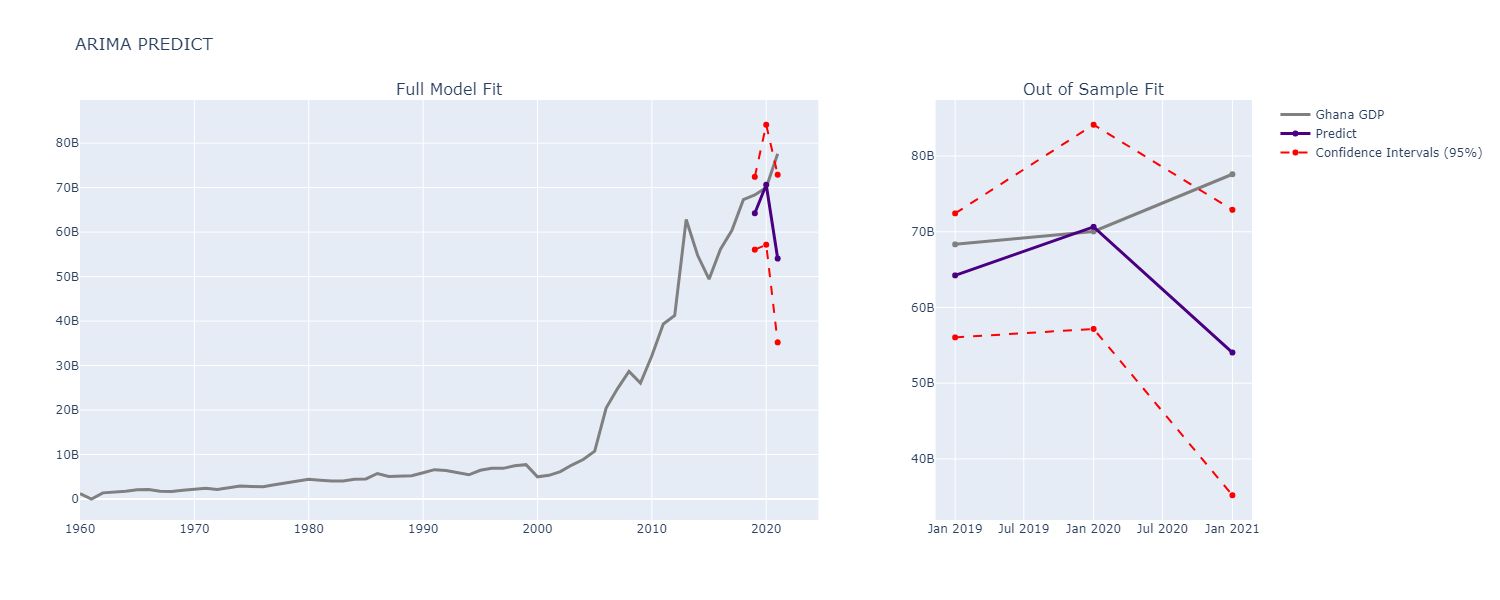

In [19]:
fig = make_subplots(rows=1, cols=2, subplot_titles=['Full Model Fit', 'Out of Sample Fit'], column_widths=[70, 30])

fig.add_trace(go.Scatter(y=pred_df['GDP (current US$)'], x= ghana_gdp.index, showlegend=True, name='Ghana GDP', line={'color':'gray', 'width':3}), row=1, col=1)
fig.add_trace(go.Scatter(y=pred_df.loc[test_ghana.index]['model_preds'], x= test_ghana.index, showlegend=True, name='Predict', line={'color':'indigo', 'width':3}), row=1, col=1)
fig.add_trace(go.Scatter(y=pred_df.loc[test_ghana.index]['model_preds_lower'], x= test_ghana.index, showlegend=True, name='Confidence Intervals (95%)', line={'color':'red', 'width':2,'dash':'dash'}), row=1, col=1)
fig.add_trace(go.Scatter(y=pred_df.loc[test_ghana.index]['model_preds_upper'], x= test_ghana.index, showlegend=False, name='Confidence Intervals (95%)', line={'color':'red', 'width':2, 'dash':'dash'}), row=1, col=1)



fig.add_trace(go.Scatter(y=pred_df.loc[test_ghana.index]['GDP (current US$)'], x= test_ghana.index, showlegend=False, name='Ghana GDP',line={'color':'gray', 'width':3}), row=1, col=2)
fig.add_trace(go.Scatter(y=pred_df.loc[test_ghana.index]['model_preds'], x= test_ghana.index, showlegend=False, line={'color':'indigo', 'width':3}), row=1, col=2)
fig.add_trace(go.Scatter(y=pred_df.loc[test_ghana.index]['model_preds_lower'], x= test_ghana.index, showlegend=False, name='Confidence Intervals_lower (95%)', line={'color':'red', 'width':2, 'dash':'dash'}), row=1, col=2)
fig.add_trace(go.Scatter(y=pred_df.loc[test_ghana.index]['model_preds_upper'], x= test_ghana.index, showlegend=False, name='Confidence Intervals_upper (95%)', line={'color':'red', 'width':2, 'dash':'dash'}), row=1, col=2)


fig.update_layout(height=600, width=1500, title_text='ARIMA PREDICT')
fig.show()

In [20]:
pred_df.tail(3)

,model_preds,GDP (current US$),model_preds_lower,model_preds_upper
year,,,,
2019-01-01,6.423538e+10,6.833754e+10,5.604903e+10,7.242172e+10
2020-01-01,7.064875e+10,7.004320e+10,5.716700e+10,8.413049e+10
2021-01-01,5.404978e+10,7.759428e+10,3.520275e+10,7.289681e+10


In [21]:
MAPE = round(mean_absolute_percentage_error(test_ghana, pred_df['model_preds'][59:62])*100, 2)
MSE = round(mean_squared_error(test_ghana, pred_df['model_preds'][59:62])*100, 2)
print(f'MAPE for ARIMA = {MAPE}%')
print(f'MSE for ARIMA = {MSE}')

MAPE for ARIMA = 12.4%
MSE for ARIMA = 1.905126060055274e+22


Модель ARIMA с оптимально подобранными параметрами показала следующие метрики:

- AIC = 2558.008
- MAPE for ARIMA = 12.4%
- MSE for ARIMA = 1.905126060055274e+22

На графике ARIMA PREDICT чётко видно, что истинное последнее значения GDP(за 2021) выходят за границы 95% интервала(верхней его границы), а значение за этот год предсказанное моделью расходятся порядка на 30%. Модель требует доработки.

## **5. Интерполяция. Построение модели на интерполированных данных**

Внимательно взглянем на наши данные на предмет наличия пропусков и наличия пропущенных дат:

In [22]:
ghana_gdp.asfreq(freq='AS')

,GDP (current US$)
year,
1960-01-01,1.217087e+09
1961-01-01,0.000000e+00
1962-01-01,1.382353e+09
1963-01-01,1.540616e+09
1964-01-01,1.731092e+09
...,...
2017-01-01,6.040638e+10
2018-01-01,6.729928e+10
2019-01-01,6.833754e+10


In [23]:
ghana_gdp.isnull().sum()

GDP (current US$)    0
dtype: int64

На первый взгляд пропущенных значений нет, но иногда пропуски в данных могут быть заполнены нулями. 

Сделаем проверку на наличие нулевых значений и в случае нахождения замените их на NaN.

In [24]:
ghana_gdp[ghana_gdp['GDP (current US$)']==0]

,GDP (current US$)
year,
1961-01-01,0.0


In [25]:
ghana_gdp['GDP (current US$)'] = ghana_gdp['GDP (current US$)'].apply(lambda x: np.nan if x==0 else x)

Теперь выполним заполнение пропуска за 1961-01-01 методом интерполяции:

In [26]:
ghana_gdp['GDP (current US$)'] = ghana_gdp['GDP (current US$)'].interpolate(method='linear')

In [27]:
train_ghana = ghana_gdp.loc[:'2018-12-31']
test_ghana = ghana_gdp.loc['2019-01-01':]
train_ghana.shape, test_ghana.shape

((59, 1), (3, 1))

Вновь проверим ряд на стационарность.

In [28]:
test = adfuller(train_ghana['GDP (current US$)'])

print ('adf: ', test[0])
print ('p-value: ', test[1])
print ('Critical values: ', test[4])

if test[0]> test[4]['5%']: 
    print ('ряд нестационарен')
else:
    print ('ряд стационарен')

adf:  0.8030073326980129
p-value:  0.9916845572455877
Critical values:  {'1%': -3.5745892596209488, '5%': -2.9239543084490744, '10%': -2.6000391840277777}
ряд нестационарен


Ряд также нестационарен. Проведём его дифференцирование.

In [29]:
df_diff_1 = train_ghana.diff(periods=2).dropna()
test = adfuller(df_diff_1['GDP (current US$)'])
print ('adf: ', test[0])
print ('p-value: ', test[1])
print ('Critical values: ', test[4])
if test[0]> test[4]['5%']: 
    print ('ряд нестационарен')
else:
    print ('ряд стационарен')

adf:  -3.999803440949147
p-value:  0.0014115408436661371
Critical values:  {'1%': -3.584828853223594, '5%': -2.9282991495198907, '10%': -2.6023438271604937}
ряд стационарен


После второго порядка дифференцирования(d=2) ряд стал стационарным. 

Взглянем на коррелограмму:

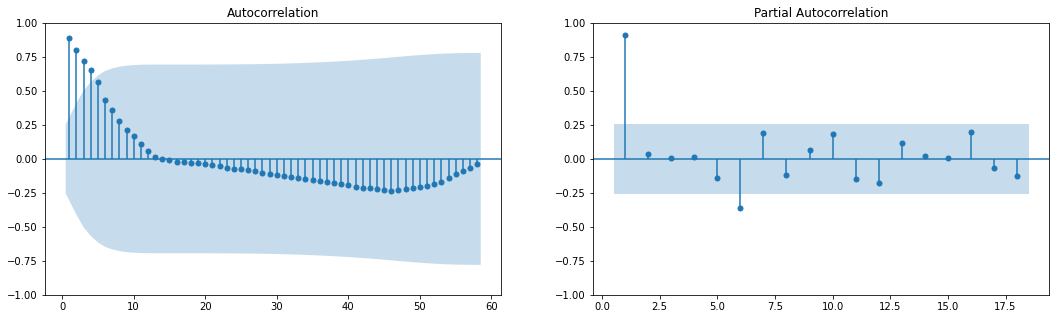

In [30]:
plot_acf_pacf(train_ghana['GDP (current US$)'])

На частичной коррелограмме отчётливо выделяется пятый лаг(p=5), на полной коррелограмме видим корреляцию до 4 лага.

Построим модель ARIMA по интерполированным данным с параметрами:

- p=5
- d=2
- q=3

In [31]:
arima_model = ARIMA(train_ghana, order = (5, 2, 3))
arima_model_fit = arima_model.fit()
arima_model_fit.summary()

c:\anaconda_adm\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency AS-JAN will be used.

c:\anaconda_adm\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency AS-JAN will be used.

c:\anaconda_adm\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency AS-JAN will be used.

c:\anaconda_adm\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

c:\anaconda_adm\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.



<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:      GDP (current US$)   No. Observations:                   59
Model:                 ARIMA(5, 2, 3)   Log Likelihood               -1328.224
Date:                Mon, 16 Jan 2023   AIC                           2674.448
Time:                        20:55:20   BIC                           2692.835
Sample:                    01-01-1960   HQIC                          2681.594
                         - 01-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4680      0.247     -1.891      0.059      -0.953       0.017
ar.L2         -0.0416      0.233     -0.178      0.858      -0.499       0.416
ar.L3         -0.3521      0.301     -1.169      0.242      -0.942       0.238
ar.L4         -0.4446      0.320     -1.390      0.164      -1.072       0.182
ar.L5         -0.0149      0.371     -0.040      0.968      -0.743       0.713
ma.L1         -0.5476      0.338     -1.622      0.105      -1.209       0.114
ma.L2         -0.6445      0.274     -2.349      0.019      -1.182      -0.107
ma.L3          0.8387      0.170      4.937      0.000       0.506       1.172
sigma2      1.205e+19   6.22e-20   1.94e+38      0.000     1.2e+19     1.2e+19
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                71.30
Prob(Q):                              0.94   Prob(JB):                         0.00
Heteroskedasticity (H):             328.82   Skew:                             0.99
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.11
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 3.65e+53. Standard errors may be unstable.
"""

Далее подберём оптимальные параметры:

In [32]:
smodel = pm.auto_arima(train_ghana, start_p=1, start_q=1,
                         test='adf',
                         max_p=16, max_q=20,                         
                         d=2, max_d=5, trace=True,
                         error_action='ignore',  
                         suppress_warnings=True,
                         seasonal=False, 
                         stepwise=True)

smodel.summary()

Performing stepwise search to minimize aic
 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=2687.479, Time=0.04 sec
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=2721.621, Time=0.01 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=2706.528, Time=0.02 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=2687.799, Time=0.02 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=2719.683, Time=0.01 sec
 ARIMA(2,2,1)(0,0,0)[0] intercept   : AIC=2686.221, Time=0.04 sec
 ARIMA(2,2,0)(0,0,0)[0] intercept   : AIC=2694.822, Time=0.02 sec
 ARIMA(3,2,1)(0,0,0)[0] intercept   : AIC=2687.929, Time=0.05 sec
 ARIMA(2,2,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.20 sec
 ARIMA(1,2,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(3,2,0)(0,0,0)[0] intercept   : AIC=2695.861, Time=0.03 sec
 ARIMA(3,2,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(2,2,1)(0,0,0)[0]             : AIC=2683.709, Time=0.03 sec
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=2684.377, Time=0.03 sec
 ARIMA(2,2,0)(0,0,0)[0]             : AIC=2692.9

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   59
Model:               SARIMAX(1, 2, 3)   Log Likelihood               -1335.257
Date:                Mon, 16 Jan 2023   AIC                           2680.513
Time:                        20:55:22   BIC                           2690.729
Sample:                    01-01-1960   HQIC                          2684.483
                         - 01-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5586      0.171     -3.271      0.001      -0.893      -0.224
ma.L1         -0.4271      0.248     -1.724      0.085      -0.913       0.059
ma.L2         -0.8246      0.185     -4.467      0.000      -1.186      -0.463
ma.L3          0.5228      0.135      3.866      0.000       0.258       0.788
sigma2      1.864e+19   1.02e-20   1.84e+39      0.000    1.86e+19    1.86e+19
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               179.81
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):             434.94   Skew:                             1.19
Prob(H) (two-sided):                  0.00   Kurtosis:                        11.37
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 7.28e+55. Standard errors may be unstable.
"""

Итак, оптимальные параметры ARIMA(1,2,3) - построим и обучим модель на них и сделаем предсказания для тестовой выборки.

In [33]:
arima_model_opt = ARIMA(train_ghana, order = (1, 2, 3))
arima_model_opt_fit = arima_model_opt.fit()
arima_model_opt_fit.summary()

c:\anaconda_adm\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency AS-JAN will be used.

c:\anaconda_adm\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency AS-JAN will be used.

c:\anaconda_adm\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency AS-JAN will be used.

c:\anaconda_adm\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.



<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:      GDP (current US$)   No. Observations:                   59
Model:                 ARIMA(1, 2, 3)   Log Likelihood               -1335.257
Date:                Mon, 16 Jan 2023   AIC                           2680.513
Time:                        20:55:22   BIC                           2690.729
Sample:                    01-01-1960   HQIC                          2684.483
                         - 01-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5586      0.171     -3.271      0.001      -0.893      -0.224
ma.L1         -0.4271      0.248     -1.724      0.085      -0.913       0.059
ma.L2         -0.8246      0.185     -4.467      0.000      -1.186      -0.463
ma.L3          0.5228      0.135      3.866      0.000       0.258       0.788
sigma2      1.864e+19   1.02e-20   1.84e+39      0.000    1.86e+19    1.86e+19
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               179.81
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):             434.94   Skew:                             1.19
Prob(H) (two-sided):                  0.00   Kurtosis:                        11.37
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 7.28e+55. Standard errors may be unstable.
"""

In [34]:
# создадим отдельный датафрейм с индексами первоначального 
pred_df = pd.DataFrame(index = ghana_gdp.index)
# сделаем предсказания для test_ghana и запишем в новый признак model_preds
pred_df['model_preds'] = arima_model_opt_fit.predict(start = test_ghana.index[0], end = test_ghana.index[-1])

# перенесём истинные значения в новый датафрейм
pred_df['GDP (current US$)'] = ghana_gdp['GDP (current US$)']
# формируем доверительный интервал в 95%
forecast = arima_model_opt_fit.get_forecast(len(test_ghana.index))
forecast_df = forecast.conf_int(alpha = 0.05) # Confidence level of 95%
# добавим в датафрейм доверительный интервал для 3 последних значений
pred_df.at[test_ghana.index, 'model_preds_lower'] = forecast_df['lower GDP (current US$)']
pred_df.at[test_ghana.index, "model_preds_upper"] = forecast_df['upper GDP (current US$)']
pred_df.tail(4)

,model_preds,GDP (current US$),model_preds_lower,model_preds_upper
year,,,,
2018-01-01,NaN,6.729928e+10,NaN,NaN
2019-01-01,6.781358e+10,6.833754e+10,5.934528e+10,7.628189e+10
2020-01-01,7.249485e+10,7.004320e+10,6.044242e+10,8.454729e+10
2021-01-01,7.509393e+10,7.759428e+10,6.145217e+10,8.873569e+10


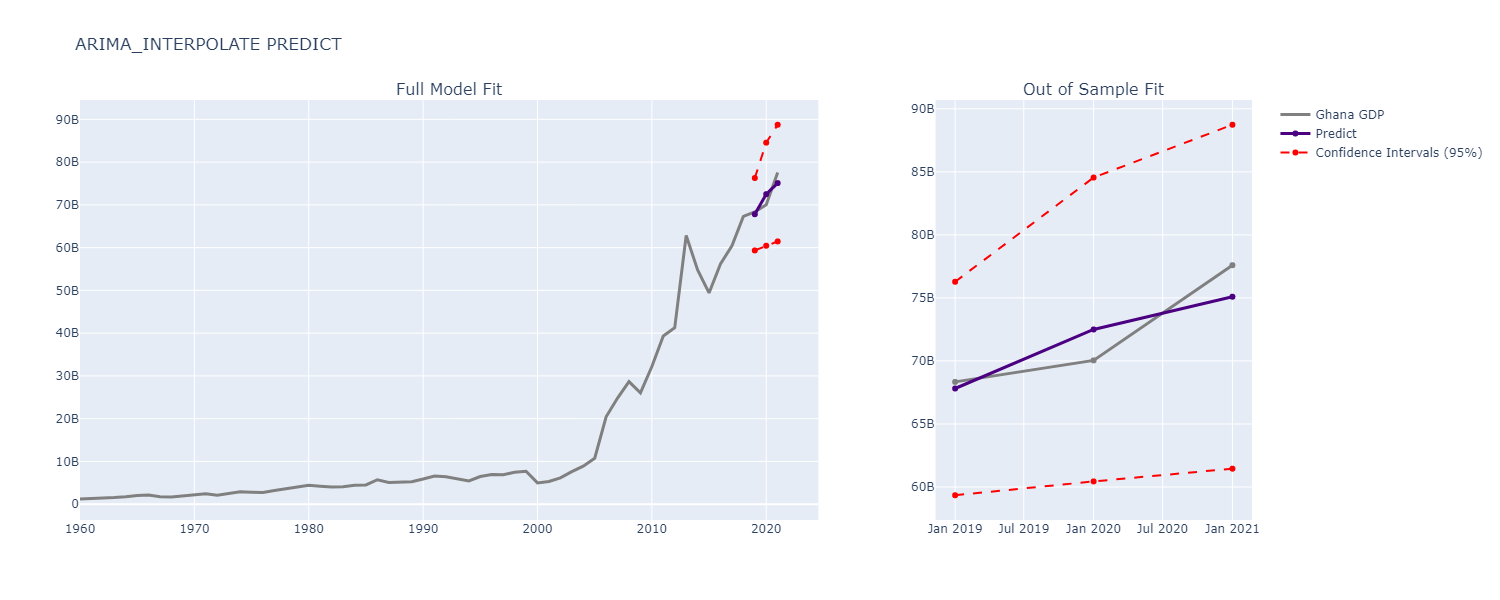

In [35]:
fig = make_subplots(rows=1, cols=2, subplot_titles=['Full Model Fit', 'Out of Sample Fit'], column_widths=[70, 30])

fig.add_trace(go.Scatter(y=pred_df['GDP (current US$)'], x= ghana_gdp.index, showlegend=True, name='Ghana GDP', line={'color':'gray', 'width':3}), row=1, col=1)
fig.add_trace(go.Scatter(y=pred_df.loc[test_ghana.index]['model_preds'], x= test_ghana.index, showlegend=True, name='Predict', line={'color':'indigo', 'width':3}), row=1, col=1)
fig.add_trace(go.Scatter(y=pred_df.loc[test_ghana.index]['model_preds_lower'], x= test_ghana.index, showlegend=True, name='Confidence Intervals (95%)', line={'color':'red', 'width':2,'dash':'dash'}), row=1, col=1)
fig.add_trace(go.Scatter(y=pred_df.loc[test_ghana.index]['model_preds_upper'], x= test_ghana.index, showlegend=False, name='Confidence Intervals (95%)', line={'color':'red', 'width':2, 'dash':'dash'}), row=1, col=1)

fig.add_trace(go.Scatter(y=pred_df.loc[test_ghana.index]['GDP (current US$)'], x= test_ghana.index, showlegend=False, name='Ghana GDP',line={'color':'gray', 'width':3}), row=1, col=2)
fig.add_trace(go.Scatter(y=pred_df.loc[test_ghana.index]['model_preds'], x= test_ghana.index, showlegend=False, line={'color':'indigo', 'width':3}), row=1, col=2)
fig.add_trace(go.Scatter(y=pred_df.loc[test_ghana.index]['model_preds_lower'], x= test_ghana.index, showlegend=False, name='Confidence Intervals_lower (95%)', line={'color':'red', 'width':2, 'dash':'dash'}), row=1, col=2)
fig.add_trace(go.Scatter(y=pred_df.loc[test_ghana.index]['model_preds_upper'], x= test_ghana.index, showlegend=False, name='Confidence Intervals_upper (95%)', line={'color':'red', 'width':2, 'dash':'dash'}), row=1, col=2)

fig.update_layout(height=600, width=1500, title_text='ARIMA_INTERPOLATE PREDICT')
fig.show()

In [36]:
pred_df.tail(3)

,model_preds,GDP (current US$),model_preds_lower,model_preds_upper
year,,,,
2019-01-01,6.781358e+10,6.833754e+10,5.934528e+10,7.628189e+10
2020-01-01,7.249485e+10,7.004320e+10,6.044242e+10,8.454729e+10
2021-01-01,7.509393e+10,7.759428e+10,6.145217e+10,8.873569e+10


In [37]:
MAPE = round(mean_absolute_percentage_error(test_ghana, pred_df['model_preds'][59:62])*100, 2)
MSE = round(mean_squared_error(test_ghana, pred_df['model_preds'][59:62])*100, 2)
print(f'MAPE for ARIMA_INTERPOLATE = {MAPE}%')
print(f'MSE for ARIMA_INTERPOLATE = {MSE}')

MAPE for ARIMA_INTERPOLATE = 2.5%
MSE for ARIMA_INTERPOLATE = 4.178956426388931e+20


Построенная модель ARIMA_INTERPOLATE на интерполированных данных несмотря на незначительно выше показатель AIC=2680.513(против ARIMA c AIC= 2558.008) хорошо себя показала на тестовых данных - истинные значения входят в построенный 95% доверительный интервал. Метрики MSE и MAPE выше, чем у моделей SMA и ARIMA:

- MAPE for ARIMA_INTERPOLATE = 2.5%
- MSE for ARIMA_INTERPOLATE = 4.178956426388931e+20

## **6. Предсказание волатильности. Модели прогнозирования гетероскедастичности.**

Рассчитаем волатильность временного ряда(в %), добавим их данные в исходный датафрейм в виде GDP_vol:

In [38]:
ghana_gdp['GDP_vol'] = ghana_gdp['GDP (current US$)'].pct_change(1).mul(100).abs()
ghana_gdp['GDP_vol'].head()

year
1960-01-01          NaN
1961-01-01     6.789413
1962-01-01     6.357759
1963-01-01    11.448835
1964-01-01    12.363636
Name: GDP_vol, dtype: float64

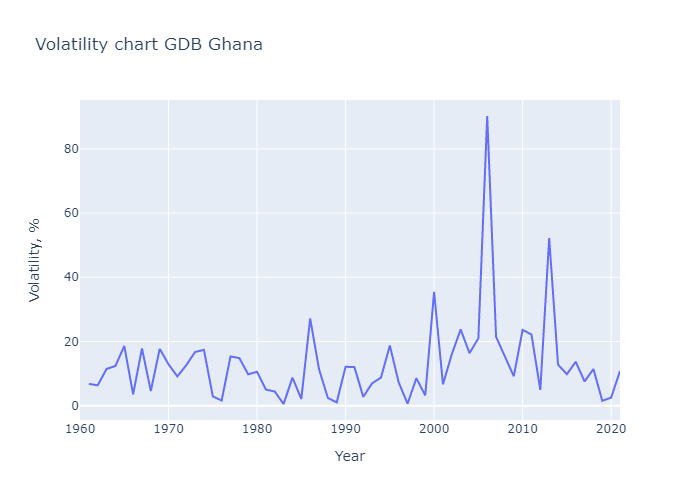

In [39]:
fig = px.line(x=ghana_gdp.index, y=ghana_gdp['GDP_vol'],
              labels={'x':'Year', 'y':'Volatility, %'},
              title='Volatility chart GDB Ghana')
fig.show()

Сразу проверим ряд на **гетероскедастичность** т.е. на неоднородность наблюдений, выражающаяся в неодинаковой дисперсии. Для этого создадим вспомогательный признак GDP_vol_sqr, где будут находиться квадраты значений и отразим их на графике.

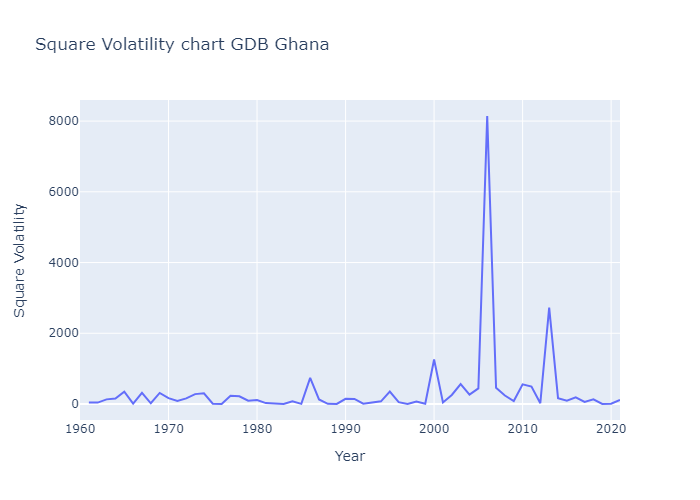

In [40]:
ghana_gdp['GDP_vol_sqr'] = ghana_gdp['GDP_vol'].apply(lambda x: x**2)

fig = px.line(x=ghana_gdp.index, y=ghana_gdp['GDP_vol_sqr'],
              labels={'x':'Year', 'y':'Square Volatility'},
              title='Square Volatility chart GDB Ghana')
fig.show()

Volatility chart GDB Ghana на всём своём периоде наблюдения характеризуется стабильной волатильностью в коридоре 20%(особенно в период 1960-1999) с выделением нескольких резких пиков:

- 1986 - в 27%
- 2000 - в 35%
- 2006 - в 90%
- 2013 - в 52%

Square Volatility chart GDB Ghana говорит о **гомоскедастичности** ряда - на всём протяжении показатели околонулевые, за исключением ранее упомянутых пиков.

Вновь разобьём данные на тестовые и тренировочные и выполним декомпозицию временного ряда:

In [41]:
train_ghana = ghana_gdp.loc[:'2018-12-31']
test_ghana = ghana_gdp.loc['2019-01-01':]
train_ghana.shape, test_ghana.shape

((59, 3), (3, 3))

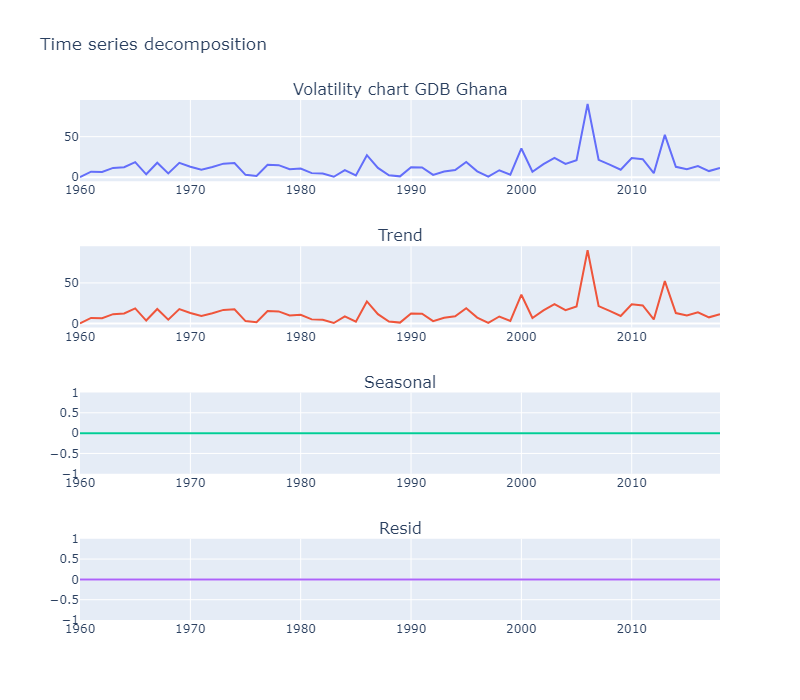

In [42]:
result = seasonal_decompose(train_ghana['GDP_vol'].fillna(0), model='additive')

fig = make_subplots(rows=4, cols=1, row_heights=[50, 50, 50, 50],subplot_titles=['Volatility chart GDB Ghana', 'Trend',
                                                    'Seasonal', 'Resid'])

fig.add_trace(go.Scatter(y=train_ghana['GDP_vol'].fillna(0), x= train_ghana.index, showlegend=False),row=1, col=1)
fig.add_trace(go.Scatter(y=result.trend, x= train_ghana.index, showlegend=False), row=2, col=1)
fig.add_trace(go.Scatter(y=result.seasonal, x= train_ghana.index, showlegend=False), row=3, col=1)
fig.add_trace(go.Scatter(y=result.resid, x= train_ghana.index, showlegend=False), row=4, col=1)

fig.update_layout(height=700, width=800, title_text='Time series decomposition')
fig.show()

Декомпозиция временного ряда сезонности(цикличности) или шума не выявила, тренд отсутсвует.

Построим коррелограммы волатильности:

In [43]:
def plot_acf_pacf(series):
    plt.rcParams["figure.figsize"] = 18, 5

    fig, axes = plt.subplots(1, 2)
    
    sgt.plot_acf(series, ax = axes[0], zero=False, lags = 57)
    sgt.plot_pacf(series, ax = axes[1], method='yw', zero=False)
    plt.show()  

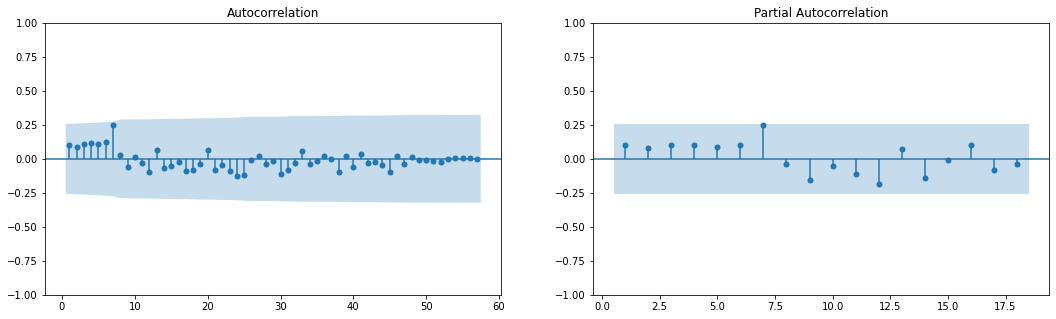

In [44]:
plot_acf_pacf(train_ghana['GDP_vol'][1:])

На графиках коррелограмм видно практически отсутствующую корреляцию со слабо выделяющимся шестым лагом, что говорит об отсутсвии тренда и цикличной составляющей.

Проверим ряд на стационарность.

In [45]:
test = adfuller(train_ghana['GDP_vol'][1:])
print ('adf: ', test[0])
print ('p-value: ', test[1])
print ('Critical values: ', test[4])
if test[0]> test[4]['5%']: 
    print ('ряд нестационарен')
else:
    print ('ряд стационарен')

adf:  -6.725311059553779
p-value:  3.4014596148856493e-09
Critical values:  {'1%': -3.5506699942762414, '5%': -2.913766394626147, '10%': -2.5946240473991997}
ряд стационарен


Будем использовать GARCH-модель для предсказания волатильности.

In [46]:
# нам важно сохранить объем датасета, поэтому берем за исходные данные весь датасет с индексами, который содержит
# и train и test часть
garch_df = pd.DataFrame(ghana_gdp['GDP_vol'].loc[ghana_gdp.index]) 

from arch import arch_model
model = arch_model(garch_df['GDP_vol'].dropna(), p = 6, q = 1, vol = "GARCH")

# в параметре last_obs указываем последний объект, до которого будем совершать обучение. 
# в нашем случае это до первого объекта из test выборки 

model_results = model.fit(last_obs = test_ghana.index[0], update_freq = 5)

model_results.summary()

Iteration:      5,   Func. Count:     59,   Neg. LLF: 220.0682255186633
Iteration:     10,   Func. Count:    113,   Neg. LLF: 214.50075278290194
Iteration:     15,   Func. Count:    164,   Neg. LLF: 214.4040845548423
Iteration:     20,   Func. Count:    214,   Neg. LLF: 214.31062291718945
Optimization terminated successfully    (Exit mode 0)
            Current function value: 214.31061699233626
            Iterations: 22
            Function evaluations: 233
            Gradient evaluations: 22


<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:                GDP_vol   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -214.311
Distribution:                  Normal   AIC:                           446.621
Method:            Maximum Likelihood   BIC:                           465.165
                                        No. Observations:                   58
Date:                Mon, Jan 16 2023   Df Residuals:                       57
Time:                        20:55:24   Df Model:                            1
                               Mean Model                               
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu            11.2445      1.422      7.909  2.592e-15 [  8.458, 14.031]
                               Volatility Model                              
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega         26.5259     29.361      0.903      0.366      [-31.020, 84.071]
alpha[1]       0.0000  1.041e-02      0.000      1.000 [-2.041e-02,2.041e-02]
alpha[2]       0.0000  1.710e-02      0.000      1.000 [-3.351e-02,3.351e-02]
alpha[3]       0.2560      0.754      0.340      0.734      [ -1.222,  1.734]
alpha[4]   6.0587e-12  8.016e-02  7.558e-11      1.000      [ -0.157,  0.157]
alpha[5]       0.0000  1.051e-02      0.000      1.000 [-2.060e-02,2.060e-02]
alpha[6]       0.6731      0.391      1.724  8.478e-02   [-9.230e-02,  1.439]
beta[1]        0.0709  8.247e-02      0.859      0.390   [-9.078e-02,  0.233]
=============================================================================

Covariance estimator: robust
"""

Сделаем предсказания и визуализиуем результат.

In [47]:
predictions_df = test_ghana.copy()
predictions_df["Predictions"] = model_results.forecast().residual_variance.loc[test_ghana.index]

c:\anaconda_adm\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning:


The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.




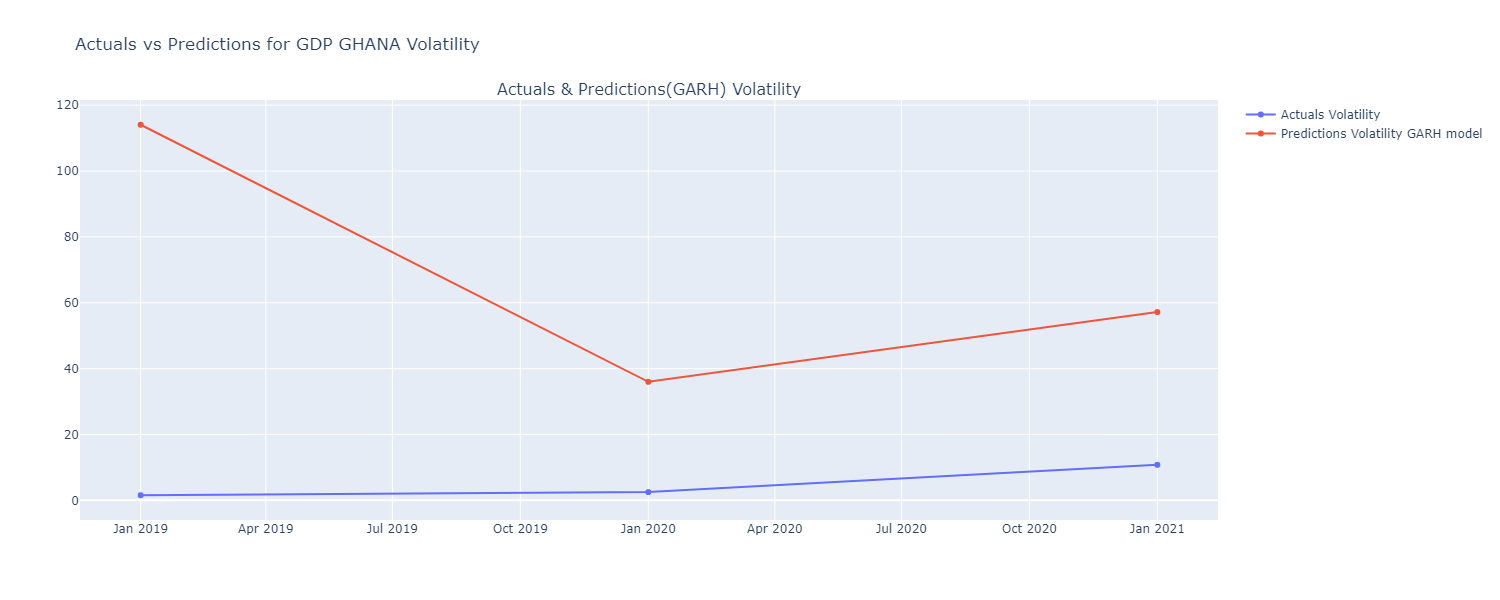

In [48]:
fig = make_subplots(rows=1, cols=1, subplot_titles=['Actuals & Predictions(GARH) Volatility'])

fig.add_trace(go.Scatter(y=predictions_df["GDP_vol"].abs(), x= test_ghana.index, showlegend=True, name='Actuals Volatility'), row=1, col=1)
fig.add_trace(go.Scatter(y=predictions_df["Predictions"], x= test_ghana.index, showlegend=True, name='Predictions Volatility GARH model'), row=1, col=1)

fig.update_layout(height=600, width=1500, title_text='Actuals vs Predictions for GDP GHANA Volatility')
fig.show()

In [49]:
MAPE = round(mean_absolute_percentage_error(predictions_df["GDP_vol"].abs(), predictions_df["Predictions"])*100, 2)
MSE = round(mean_squared_error(predictions_df["GDP_vol"].abs(), predictions_df["Predictions"])*100, 2)
print(f'MAPE for GARCH = {MAPE}%')
print(f'MSE for GARCH = {MSE}')

MAPE for GARCH = 3021.48%
MSE for GARCH = 530989.65


Теперь сделаем модель на основе линейной регрессии.

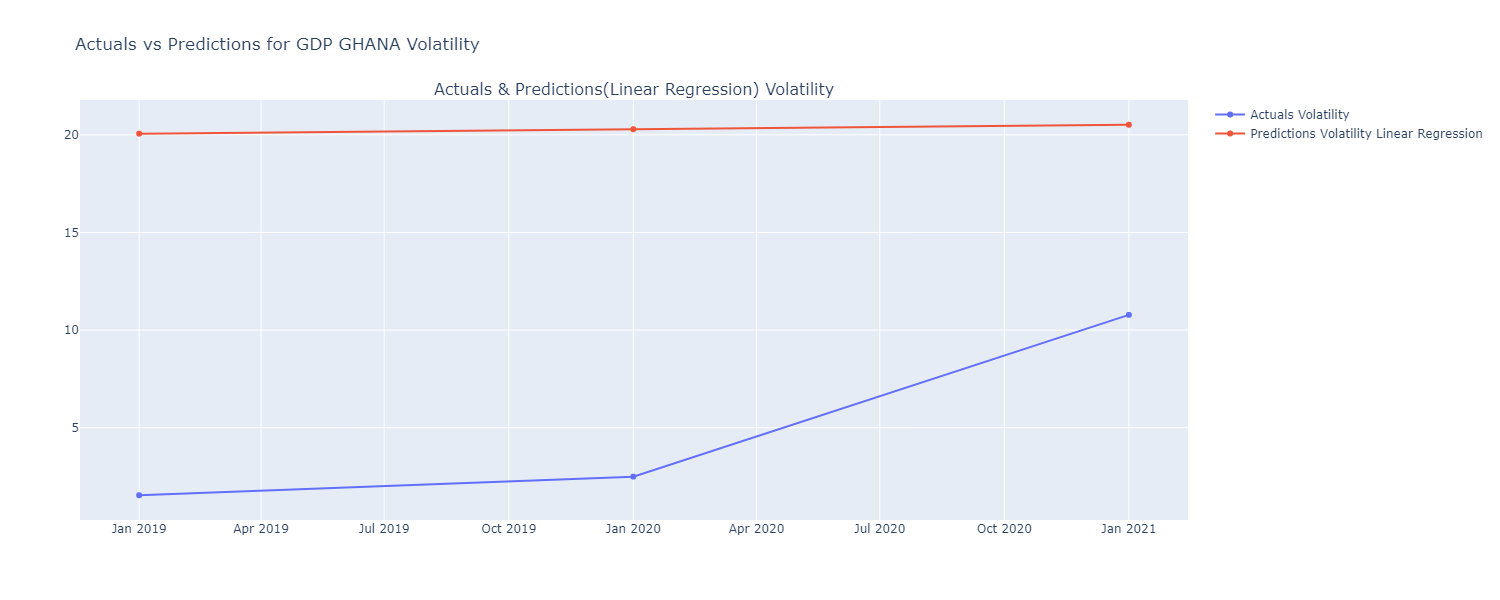

In [50]:
X_train = pd.DataFrame(range(ghana_gdp['GDP_vol'].shape[0]))[:train_ghana.shape[0]].fillna(0)
X_test = pd.DataFrame(range(ghana_gdp['GDP_vol'].shape[0]))[train_ghana.shape[0]:].fillna(0)
y_train = train_ghana['GDP_vol'].fillna(0)
y_test = test_ghana['GDP_vol'].fillna(0)

lr = LinearRegression()
lr.fit(X_train, y_train)
lr_predict = lr.predict(X_test)

fig = make_subplots(rows=1, cols=1, subplot_titles=['Actuals & Predictions(Linear Regression) Volatility'])

fig.add_trace(go.Scatter(y=y_test, x= y_test.index, showlegend=True, name='Actuals Volatility'), row=1, col=1)
fig.add_trace(go.Scatter(y=lr_predict, x= y_test.index, showlegend=True, name='Predictions Volatility Linear Regression'), row=1, col=1)

fig.update_layout(height=600, width=1500, title_text='Actuals vs Predictions for GDP GHANA Volatility')
fig.show()

In [51]:
MAPE = round(mean_absolute_percentage_error(y_test, lr_predict)*100, 2)
MSE = round(mean_squared_error(y_test, lr_predict)*100, 2)
print(f'MAPE for LinearRegression_Volatility= {MAPE}%')
print(f'MSE for LinearRegression_Volatility = {MSE}')

MAPE for LinearRegression_Volatility= 667.81%
MSE for LinearRegression_Volatility = 25140.89


Судя по полученному графику, модель GARCH не уловила дисперсию, так как такое поведение было для неё новым и подобные случаи отсутствовали в обучающей выборке. Также ранее мы выявили, что ряд являетcя гомоскедастичным и обладаем слабой дисперсией на всём своём протяжении(за исключением 4 выбросов). Поэтому модель GARCH показала себя слабо даже в сравнении линейной регрессии(где показатели метрики лучше в 20 раз) т.к. рассчитана для предсказания изменения дисперсии во времени и учитывает сильные разбросы.

## **7. PROPHET**

Prophet — это метод прогнозирования данных временных рядов на основе AR-модели, в которой учтены годовая, еженедельная и ежедневная сезонности, а также эффекты праздничных дней.

In [52]:
ghana_gdp_zip = pd.read_csv('C:\Python\data\ghana_gdp.zip', index_col=['year'], parse_dates=['year'])
ghana_gdp = ghana_gdp_zip.copy()
ghana_gdp.head()

,GDP (current US$)
year,
1960-01-01,1.217087e+09
1961-01-01,0.000000e+00
1962-01-01,1.382353e+09
1963-01-01,1.540616e+09
1964-01-01,1.731092e+09


Преобразуем данные - датасет должен состоять из 2 признаков:

- Столбец DS (отметка даты) должен иметь временной формат (DateTime), например ГГГГ-ММ-ДД — для даты или ГГГГ-ММ-ДД ЧЧ:ММ:СС — для отметки времени.
- Столбец Y должен быть числовым и представлять измерение, которое мы хотим спрогнозировать.

In [53]:
ghana_gdp['ds'] = ghana_gdp.index
ghana_gdp['y'] = ghana_gdp['GDP (current US$)']
ghana_gdp = ghana_gdp.reset_index()
ghana_gdp = ghana_gdp.drop(['year', 'GDP (current US$)'], axis=1)
ghana_gdp.head()

,ds,y
0,1960-01-01,1.217087e+09
1,1961-01-01,0.000000e+00
2,1962-01-01,1.382353e+09
3,1963-01-01,1.540616e+09
4,1964-01-01,1.731092e+09


In [54]:
# разделим датасет на тестовый и тренировочный
train_ghana = ghana_gdp[ghana_gdp['ds'] < '2018-12-31']
test_ghana = ghana_gdp[ghana_gdp['ds'] > '2018-12-31']
train_ghana.shape, test_ghana.shape

((59, 2), (3, 2))

In [55]:
model = Prophet()
model.fit(train_ghana)
forecast_df = model.predict(test_ghana)
forecast_df[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

20:55:25 - cmdstanpy - INFO - Chain [1] start processing
20:55:26 - cmdstanpy - INFO - Chain [1] done processing


,ds,yhat,yhat_lower,yhat_upper
0,2019-01-01,3.673415e+10,2.154386e+10,5.146794e+10
1,2020-01-01,3.708702e+10,2.210713e+10,5.129250e+10
2,2021-01-01,3.933184e+10,2.492148e+10,5.315563e+10


В результате построения прогноза каждому DS будет присвоено прогнозируемое значение (YHAT). Также в прогнозном датафрейме будут два новых столбца ('yhat_lower', 'yhat_upper'), в которых будут находиться верхняя и нижняя границы доверительного интервала.

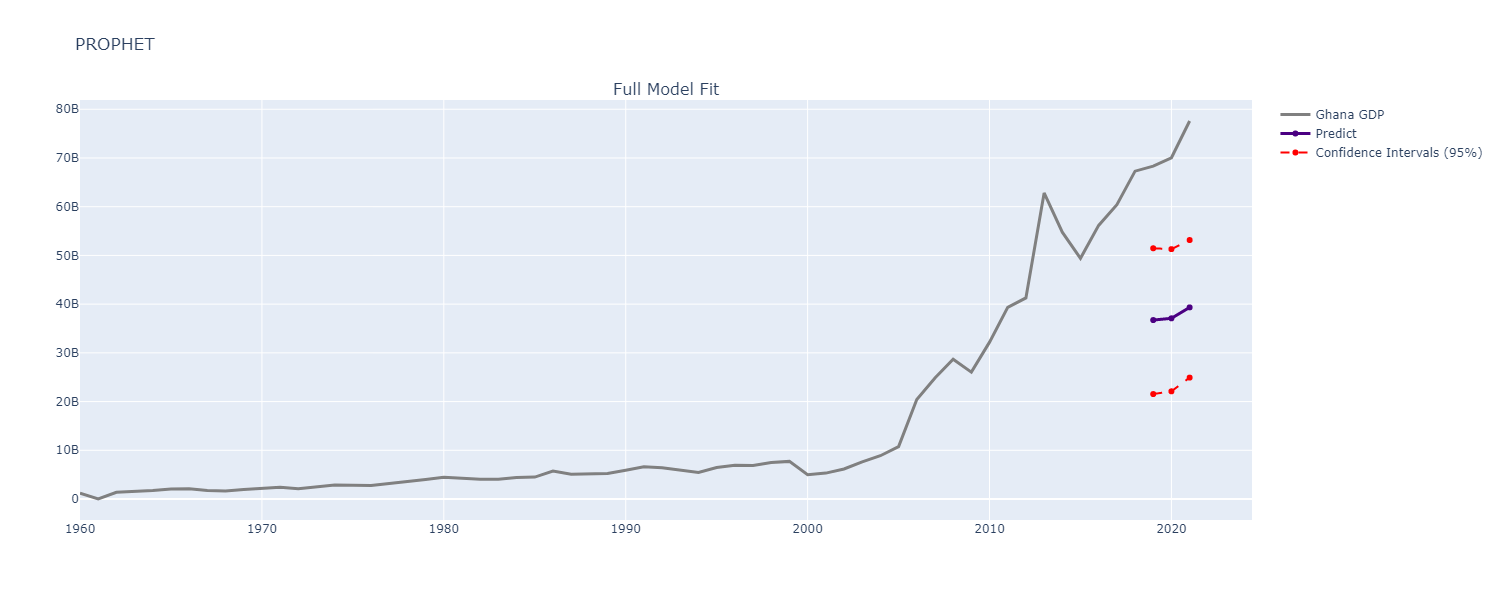

In [56]:
fig = make_subplots(rows=1, cols=1, subplot_titles=['Full Model Fit'])

fig.add_trace(go.Scatter(y=ghana_gdp_zip['GDP (current US$)'], x= ghana_gdp_zip.index, showlegend=True, name='Ghana GDP', line={'color':'gray', 'width':3}), row=1, col=1)
fig.add_trace(go.Scatter(y=forecast_df['yhat'], x= forecast_df['ds'], showlegend=True, name='Predict', line={'color':'indigo', 'width':3}), row=1, col=1)
fig.add_trace(go.Scatter(y=forecast_df['yhat_lower'], x= forecast_df['ds'], showlegend=True, name='Confidence Intervals (95%)', line={'color':'red', 'width':2,'dash':'dash'}), row=1, col=1)
fig.add_trace(go.Scatter(y=forecast_df['yhat_upper'], x= forecast_df['ds'], showlegend=False, name='Confidence Intervals (95%)', line={'color':'red', 'width':2, 'dash':'dash'}), row=1, col=1)

fig.update_layout(height=600, width=1500, title_text='PROPHET')
fig.show()

In [57]:
MAPE = round(mean_absolute_percentage_error(test_ghana['y'], forecast_df['yhat']) * 100, 2)
MSE = round(mean_squared_error(test_ghana['y'], forecast_df['yhat']) * 100, 2)
print(f'MAPE for Prophet= {MAPE}%')
print(f'MSE for Prophet = {MSE}')

MAPE for Prophet= 47.54%
MSE for Prophet = 1.182965932327517e+23


Явно видим, что предсказание модели Prophet даже близко не уловило тенденцию и истинные значения GDP далеки от доверительного интервала. Объяснить это можно тем, что Prophet лучше всего работает с временными рядами, которые имеют сильные сезонные эффекты, а данные накоплены за несколько сезонов, что является не нашим случаем - в отсутствие какой-либо сезонности.

## **8. Итоги**

В ходе анализа ВВП африканской страны Гана за период равным 62 года(с 1960 по 2021 гг.):

- График ВВП показавший восходящий тренд с 2004 г. и имевшую очень слабое увеличение с 1960 по 2004(ВВП за этот период в 44 года увеличилось только в 3 раза). Ряд характеризуется отсутсвием всякой сезонности(цикличности), шум в нуле. Модель SMA на разных окнах данные подкрепила.

- Проведение тестов выявило нестационарность ряда, что повлияло на выбор модели в сторону **ARIMA**

- В данных имелся пропуск за 1961 год(равнялся 0), данный пропуск был был обработан и заполнен методом интерполяции. После чего была построена повторно модель **ARIMA** на интерполированных данных. Подбор оптимальных параметров модели осуществлялся с помощью функции auto_arima. На интерполированных данных удалось улучшить метрику MAPE=2.5% и MAE.

- Выполнен анализ волатильности ВВП. 
Ряд волотильности оказался стационарным и гомоскедастичным со слабой дисперсией(не превышающей 20%), но имеюший 4 резких пика в:
    - 1986 - в 27%
    - 2000 - в 35%
    - 2006 - в 90%
    - 2013 - в 52%

Построенная модель GARH для предсказания волатильности ВВП не оправдала себя - модель зависимости дисперсии не уловила. Тренд и сезонность(цикличность) отсутствовала. На коррелограммах лаги очень слабо скоррелированы - что говорит опять же об отсутсвии тренда и сезонности либо ряд содержит нелинейную компоненту. В сравнении с линейной регрессией показала результаты слабее.

- Для эксперимента была построена модель PROPHET,  по результатам не оправдавшая себя - модель не подошла для нашего случая из-за отсутствия сезонности(цикличности).


В итоге была выбрана модель **ARIMA** на интерполированных данных с подобранными оптимальными параметрами ARIMA(1,2,3). Выполним предсказание ВВП Ганы с помощью этой модели за 2022 год и сравним с фактическим результатом в 2023.

In [58]:
ghana_gdp_zip = pd.read_csv('C:\Python\data\ghana_gdp.zip', index_col=['year'], parse_dates=['year'])
ghana_gdp = ghana_gdp_zip.copy()
ghana_gdp.head()

,GDP (current US$)
year,
1960-01-01,1.217087e+09
1961-01-01,0.000000e+00
1962-01-01,1.382353e+09
1963-01-01,1.540616e+09
1964-01-01,1.731092e+09


In [59]:
ghana_gdp['GDP (current US$)'] = ghana_gdp['GDP (current US$)'].apply(lambda x: np.nan if x==0 else x)
ghana_gdp['GDP (current US$)'] = ghana_gdp['GDP (current US$)'].interpolate(method='linear')

In [60]:
gdp_2022 = pd.DataFrame(index=[pd.to_datetime('2022-01-01')], columns=['GDP (current US$)'])
ghana_gdp_new = pd.concat([ghana_gdp, gdp_2022], axis=0)
ghana_gdp_new.tail(4)

,GDP (current US$)
2019-01-01,6.833754e+10
2020-01-01,7.004320e+10
2021-01-01,7.759428e+10
2022-01-01,NaN


In [61]:
train_ghana = ghana_gdp_new.loc[:'2018-12-31']
test_ghana = ghana_gdp_new.loc['2018-12-31':]
train_ghana.shape, test_ghana.shape

((59, 1), (4, 1))

In [62]:
arima_model = ARIMA(train_ghana, order = (1, 2, 3))
arima_model_fit = arima_model_opt.fit()
arima_model_fit.summary()

c:\anaconda_adm\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency AS-JAN will be used.

c:\anaconda_adm\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency AS-JAN will be used.

c:\anaconda_adm\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency AS-JAN will be used.

c:\anaconda_adm\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.



<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:      GDP (current US$)   No. Observations:                   59
Model:                 ARIMA(1, 2, 3)   Log Likelihood               -1335.257
Date:                Mon, 16 Jan 2023   AIC                           2680.513
Time:                        20:55:27   BIC                           2690.729
Sample:                    01-01-1960   HQIC                          2684.483
                         - 01-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5586      0.171     -3.271      0.001      -0.893      -0.224
ma.L1         -0.4271      0.248     -1.724      0.085      -0.913       0.059
ma.L2         -0.8246      0.185     -4.467      0.000      -1.186      -0.463
ma.L3          0.5228      0.135      3.866      0.000       0.258       0.788
sigma2      1.864e+19   1.02e-20   1.84e+39      0.000    1.86e+19    1.86e+19
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               179.81
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):             434.94   Skew:                             1.19
Prob(H) (two-sided):                  0.00   Kurtosis:                        11.37
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 7.28e+55. Standard errors may be unstable.
"""

In [63]:
smodel = pm.auto_arima(train_ghana, start_p=1, start_q=1,
                         test='adf',
                         max_p=16, max_q=20,                         
                         d=2, max_d=5, trace=True,
                         error_action='ignore',  
                         suppress_warnings=True,
                         seasonal=False, 
                         stepwise=True)

smodel.summary()

Performing stepwise search to minimize aic
 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=2687.479, Time=0.03 sec
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=2721.621, Time=0.01 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=2706.528, Time=0.02 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=2687.799, Time=0.02 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=2719.683, Time=0.01 sec
 ARIMA(2,2,1)(0,0,0)[0] intercept   : AIC=2686.221, Time=0.04 sec
 ARIMA(2,2,0)(0,0,0)[0] intercept   : AIC=2694.822, Time=0.02 sec
 ARIMA(3,2,1)(0,0,0)[0] intercept   : AIC=2687.929, Time=0.06 sec
 ARIMA(2,2,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(1,2,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(3,2,0)(0,0,0)[0] intercept   : AIC=2695.861, Time=0.03 sec
 ARIMA(3,2,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(2,2,1)(0,0,0)[0]             : AIC=2683.709, Time=0.03 sec
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=2684.377, Time=0.03 sec
 ARIMA(2,2,0)(0,0,0)[0]             : AIC=2692.9

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   59
Model:               SARIMAX(1, 2, 3)   Log Likelihood               -1335.257
Date:                Mon, 16 Jan 2023   AIC                           2680.513
Time:                        20:55:29   BIC                           2690.729
Sample:                    01-01-1960   HQIC                          2684.483
                         - 01-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5586      0.171     -3.271      0.001      -0.893      -0.224
ma.L1         -0.4271      0.248     -1.724      0.085      -0.913       0.059
ma.L2         -0.8246      0.185     -4.467      0.000      -1.186      -0.463
ma.L3          0.5228      0.135      3.866      0.000       0.258       0.788
sigma2      1.864e+19   1.02e-20   1.84e+39      0.000    1.86e+19    1.86e+19
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               179.81
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):             434.94   Skew:                             1.19
Prob(H) (two-sided):                  0.00   Kurtosis:                        11.37
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 7.28e+55. Standard errors may be unstable.
"""

In [64]:
arima_model_opt = ARIMA(train_ghana, order = (1, 2, 3))
arima_model_opt_fit = arima_model_opt.fit()
arima_model_opt_fit.summary()

c:\anaconda_adm\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency AS-JAN will be used.

c:\anaconda_adm\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency AS-JAN will be used.

c:\anaconda_adm\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency AS-JAN will be used.

c:\anaconda_adm\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.



<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:      GDP (current US$)   No. Observations:                   59
Model:                 ARIMA(1, 2, 3)   Log Likelihood               -1335.257
Date:                Mon, 16 Jan 2023   AIC                           2680.513
Time:                        20:55:29   BIC                           2690.729
Sample:                    01-01-1960   HQIC                          2684.483
                         - 01-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5586      0.171     -3.271      0.001      -0.893      -0.224
ma.L1         -0.4271      0.248     -1.724      0.085      -0.913       0.059
ma.L2         -0.8246      0.185     -4.467      0.000      -1.186      -0.463
ma.L3          0.5228      0.135      3.866      0.000       0.258       0.788
sigma2      1.864e+19   1.02e-20   1.84e+39      0.000    1.86e+19    1.86e+19
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               179.81
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):             434.94   Skew:                             1.19
Prob(H) (two-sided):                  0.00   Kurtosis:                        11.37
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 7.28e+55. Standard errors may be unstable.
"""

In [65]:
# создадим отдельный датафрейм с индексами первоначального 
pred_df = pd.DataFrame(index = ghana_gdp_new.index)
# сделаем предсказания для test_ghana и запишем в новый признак model_preds
pred_df['model_preds'] = arima_model_opt_fit.predict(start = test_ghana.index[0], end = test_ghana.index[-1])

# перенесём истинные значения в новый датафрейм
pred_df['GDP (current US$)'] = ghana_gdp_new['GDP (current US$)']
# формируем доверительный интервал в 95%
forecast = arima_model_opt_fit.get_forecast(len(test_ghana.index))
forecast_df = forecast.conf_int(alpha = 0.05) # Confidence level of 95%
# добавим в датафрейм доверительный интервал для 3 последних значений
pred_df.at[test_ghana.index, 'model_preds_lower'] = forecast_df['lower GDP (current US$)']
pred_df.at[test_ghana.index, "model_preds_upper"] = forecast_df['upper GDP (current US$)']
pred_df.tail(4)

,model_preds,GDP (current US$),model_preds_lower,model_preds_upper
2019-01-01,6.781358e+10,6.833754e+10,5.934528e+10,7.628189e+10
2020-01-01,7.249485e+10,7.004320e+10,6.044242e+10,8.454729e+10
2021-01-01,7.509393e+10,7.759428e+10,6.145217e+10,8.873569e+10
2022-01-01,7.885612e+10,NaN,6.199712e+10,9.571512e+10


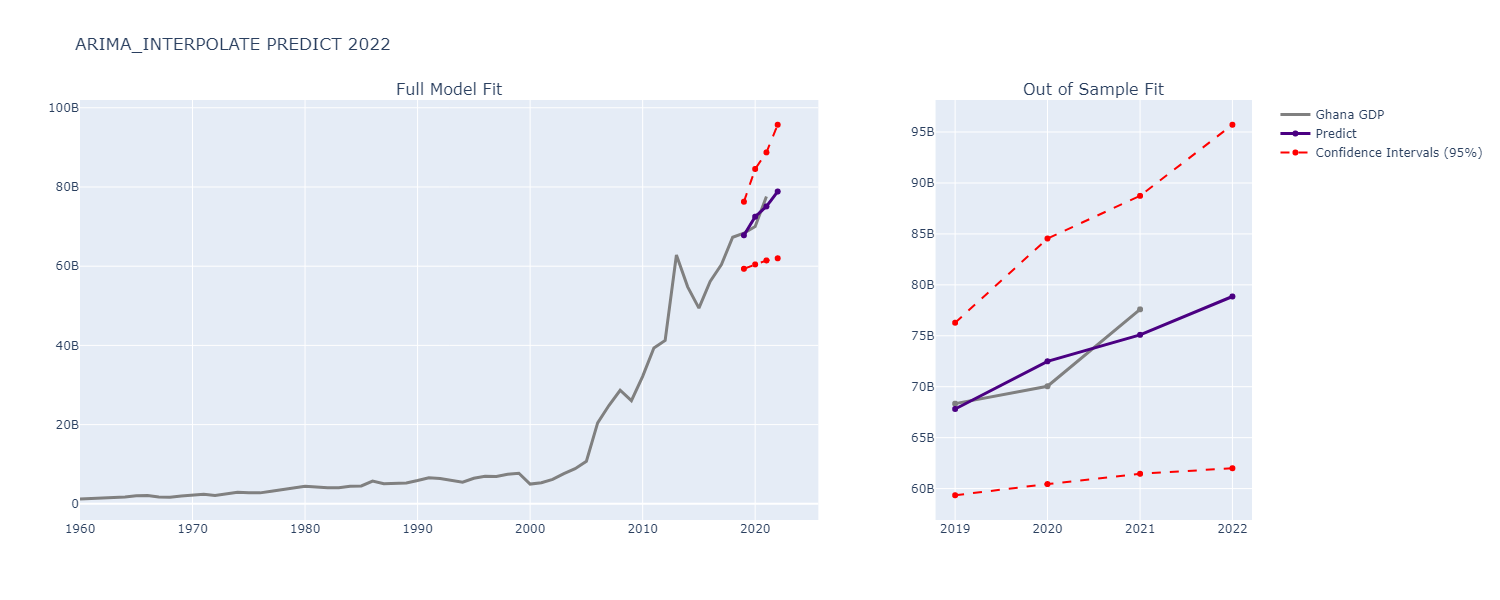

In [66]:
fig = make_subplots(rows=1, cols=2, subplot_titles=['Full Model Fit', 'Out of Sample Fit'], column_widths=[70, 30])

fig.add_trace(go.Scatter(y=pred_df['GDP (current US$)'], x= ghana_gdp_new.index, showlegend=True, name='Ghana GDP', line={'color':'gray', 'width':3}), row=1, col=1)
fig.add_trace(go.Scatter(y=pred_df.loc[test_ghana.index]['model_preds'], x= test_ghana.index, showlegend=True, name='Predict', line={'color':'indigo', 'width':3}), row=1, col=1)
fig.add_trace(go.Scatter(y=pred_df.loc[test_ghana.index]['model_preds_lower'], x= test_ghana.index, showlegend=True, name='Confidence Intervals (95%)', line={'color':'red', 'width':2,'dash':'dash'}), row=1, col=1)
fig.add_trace(go.Scatter(y=pred_df.loc[test_ghana.index]['model_preds_upper'], x= test_ghana.index, showlegend=False, name='Confidence Intervals (95%)', line={'color':'red', 'width':2, 'dash':'dash'}), row=1, col=1)

fig.add_trace(go.Scatter(y=pred_df.loc[test_ghana.index]['GDP (current US$)'], x= test_ghana.index, showlegend=False, name='Ghana GDP',line={'color':'gray', 'width':3}), row=1, col=2)
fig.add_trace(go.Scatter(y=pred_df.loc[test_ghana.index]['model_preds'], x= test_ghana.index, showlegend=False, line={'color':'indigo', 'width':3}), row=1, col=2)
fig.add_trace(go.Scatter(y=pred_df.loc[test_ghana.index]['model_preds_lower'], x= test_ghana.index, showlegend=False, name='Confidence Intervals_lower (95%)', line={'color':'red', 'width':2, 'dash':'dash'}), row=1, col=2)
fig.add_trace(go.Scatter(y=pred_df.loc[test_ghana.index]['model_preds_upper'], x= test_ghana.index, showlegend=False, name='Confidence Intervals_upper (95%)', line={'color':'red', 'width':2, 'dash':'dash'}), row=1, col=2)

fig.update_layout(height=600, width=1500, title_text='ARIMA_INTERPOLATE PREDICT 2022')
fig.show()

Модель предсказала ВВП Ганы за 2022 год равное 7.885612e+10(78,89 млрд) USD с разбросом значения в диапазоне доверительного интервала - [6.199712e+10 , 9.571512e+10]. Сразу стоит отметить, что темп роста ВВП по прогнозным данным должен существенно замедлиться -  с почти 11%(2021) до 1,7%(2022).